<a href="https://colab.research.google.com/github/LaraR2101/peptide-RT-in-RPLC/blob/main/peptideRT_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_og = '/content/drive/MyDrive/RT_Files/retention_time.hdf5'



file_mean_100 = '/content/drive/MyDrive/RT_Files/RT_100_meanRT.hdf5'

file_mean_100_ox = '/content/drive/MyDrive/RT_Files/RT_100_mean_onlyOx.hdf5'

file_mean_100_noOx = '/content/drive/MyDrive/RT_Files/RT_100_mean_noOx.hdf5'


## Data Analysis

Length after preprocessing

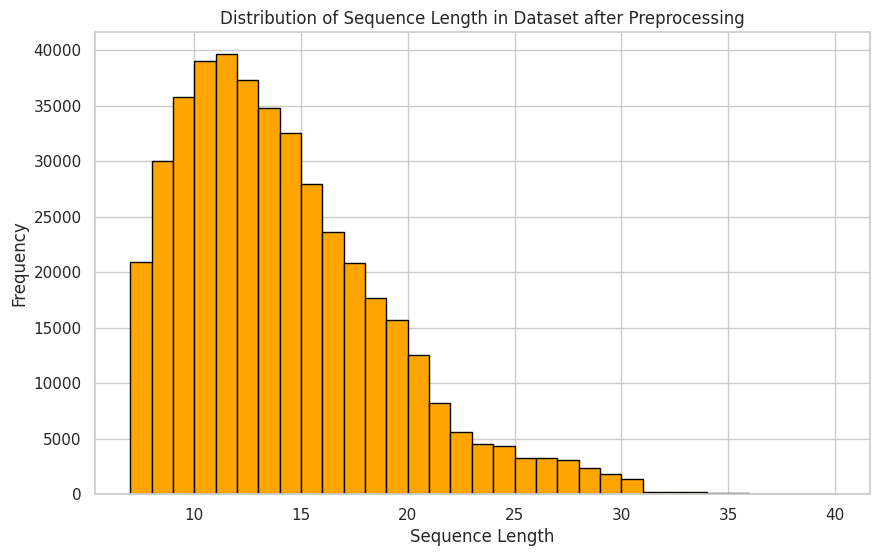

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

with h5py.File(file_mean_100, 'r') as file:
    if 'length' in file:
        length_data = np.array(file['length'])

        plt.figure(figsize=(10, 6))
        bins = np.arange(7, 41, 1)  # Create bins for each unique value from 7 to 40
        plt.hist(length_data, bins=bins, color='orange', edgecolor='black')

        # labels and title
        plt.xlabel('Sequence Length')
        plt.ylabel('Frequency')
        plt.title('Distribution of Sequence Length in Dataset after Preprocessing')

        plt.show()
    else:
        print("Dataset 'length' not found in the HDF5 file.")


## RT

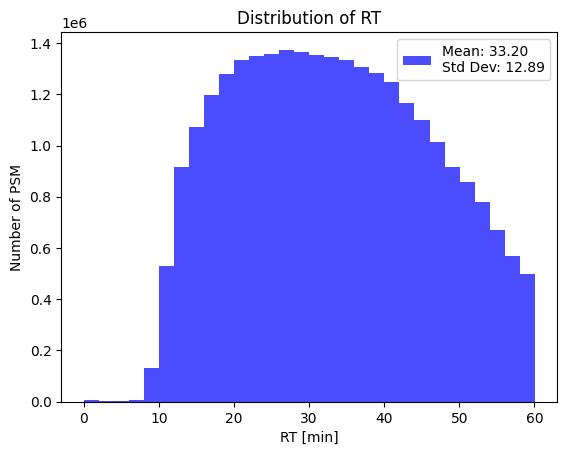

<bound method File.close of <HDF5 file "retention_time.hdf5" (mode r)>>

In [ ]:
#percentage of data with score below 70 and histogram of distribution

import h5py
import numpy as np
import matplotlib.pyplot as plt

file = h5py.File(file_og, 'r')

dataset = file['retention_time']

data_array = np.array(dataset)

# Calculate the total number of data points
total_count = len(data_array)

# histogram:

plt.hist(data_array, bins=30, color='blue', alpha=0.7)
plt.xlabel('RT [min]')
plt.ylabel('Number of PSM')
plt.title('Distribution of RT')

mean = np.mean(data_array)
std_dev = np.std(data_array)

# Add a legend
plt.legend([f'Mean: {mean:.2f}\nStd Dev: {std_dev:.2f}'])

# Remove the grid
plt.grid(False)

plt.show()

file.close

## Oxidation

Zero (ox): 23737881
One (ox): 3256958
Two (ox): 349937
Three (ox): 25696
Four (ox): 1891
Five (ox): 107


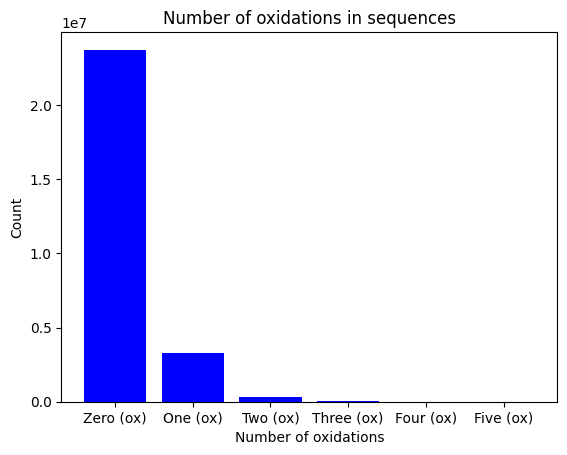

In [ ]:
from scipy.sparse import spmatrix
import h5py
import numpy as np
import re
import matplotlib.pyplot as plt

# Define a function to count occurrences of "(ox)" in a string
def count_ox_occurrences(string):
    return len(re.findall(r'\(ox\)', string))

# Initialize counters for different counts
zero_count = 0
one_count = 0
two_count = 0
three_count = 0
four_count = 0
five_count = 0

with h5py.File(file_og, 'r') as hdf5_file:
    sequence_dataset = hdf5_file['sequence']

    # Iterate through the dataset
    for row in sequence_dataset:
        # Convert the row to a string
        row_str = row.decode('utf-8')

        ox_count = count_ox_occurrences(row_str)

        if ox_count == 0:
            zero_count += 1
        elif ox_count == 1:
            one_count += 1
        elif ox_count == 2:
            two_count += 1
        elif ox_count == 3:
            three_count += 1
        elif ox_count == 4:
            four_count += 1
        elif ox_count == 5:
            five_count += 1

# Print counts to the console
print("Zero (ox):", zero_count)
print("One (ox):", one_count)
print("Two (ox):", two_count)
print("Three (ox):", three_count)
print("Four (ox):", four_count)
print("Five (ox):", five_count)

# Plotting the bar chart
counts = [zero_count, one_count, two_count, three_count, four_count, five_count]
labels = ['Zero (ox)', 'One (ox)', 'Two (ox)', 'Three (ox)', 'Four (ox)', 'Five (ox)']

plt.bar(labels, counts, color='blue')
plt.xlabel('Number of oxidations')
plt.ylabel('Count')
plt.title('Number of oxidations in sequences')
plt.show()


## Score

Percentage of data points below 70: 31.98%
Maximum score value: 574.97


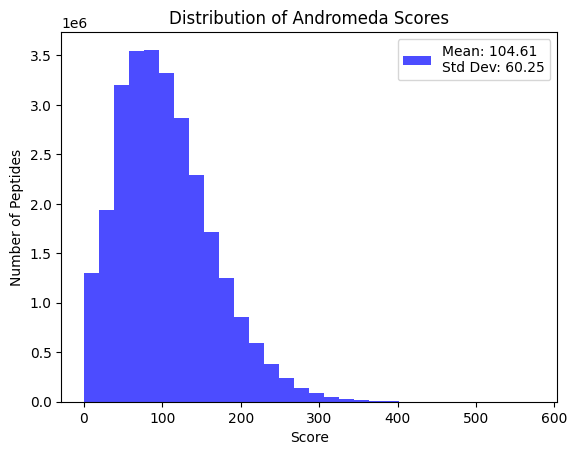

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt


file = h5py.File(file_og, 'r')

dataset = file['score']

# Extract the dataset values into a NumPy array
data_array = np.array(dataset)

# Find the maximum score value
max_score = np.max(data_array)

# Count the number of data points below 70
below_70_count = len(data_array[data_array < 70])

# Calculate the total number of data points
total_count = len(data_array)

# Calculate the percentage of data points below 70
percentage_below_70 = (below_70_count / total_count) * 100

print(f"Percentage of data points below 70: {percentage_below_70:.2f}%")
print(f"Maximum score value: {max_score:.2f}")

# Histogram:
plt.hist(data_array, bins=30, color='blue', alpha=0.7)
plt.xlabel('Score')
plt.ylabel('Number of Peptides')
plt.title('Distribution of Andromeda Scores')

mean = np.mean(data_array)
std_dev = np.std(data_array)

# Add a legend
plt.legend([f'Mean: {mean:.2f}\nStd Dev: {std_dev:.2f}'])

# Remove the grid
plt.grid(False)

plt.show()

file.close()


# **Data preprocessing**

## removing score cutoff and removing duplicated with (median and mean) RT

In [ ]:
#deletes all rows with a score below 100

import h5py
import numpy as np

# Open the original HDF5 file in read-write mode
with h5py.File(file_100, 'r+') as h5file:
    # Access the datasets
    score_data = h5file['score'][:]
    sequence_data = h5file['sequence'][:]
    retention_time_data = h5file['retention_time'][:]

    # Find the indices where 'score' is greater than or equal to 100
    valid_indices = np.where(score_data >= 100)

    # Delete the datasets
    del h5file['score']
    del h5file['sequence']
    del h5file['retention_time']

    # Create new datasets in the original file
    h5file.create_dataset('score', data=score_data[valid_indices])
    h5file.create_dataset('sequence', data=sequence_data[valid_indices])
    h5file.create_dataset('retention_time', data=retention_time_data[valid_indices])

In [ ]:
#removes duplicates and calculates median RT
#retention_time dataset name now: median_retention_time !

import h5py
import numpy as np
from collections import defaultdict

#og_file = '/content/drive/MyDrive/RT_Files/RT_above70.hdf5'

new_file = '/content/drive/MyDrive/RT_Files/RT_100_medianRT.hdf5'

with h5py.File(file_100, 'r') as file:
    sequences = file['sequence'][:]
    retention_times = file['retention_time'][:]

# Determine the maximum length of the sequences
max_sequence_length = max(len(sequence) for sequence in sequences)

# Create a dictionary to store the occurrences of each sequence and their corresponding retention times
sequence_occurrences = defaultdict(list)
for i, sequence in enumerate(sequences):
    sequence_occurrences[sequence].append(retention_times[i])

# Calculate the median retention time for each unique sequence
median_retention_times = {}
for sequence, occurrence_times in sequence_occurrences.items():
    median_retention_times[sequence] = np.median(occurrence_times)

# Create a new HDF5 file and save the unique sequences along with their median retention times
with h5py.File(new_file, 'w') as file:
    file.create_dataset('sequence', data=list(median_retention_times.keys()), dtype='S{}'.format(max_sequence_length))
    file.create_dataset('median_retention_time', data=list(median_retention_times.values()), dtype=np.float64)

In [ ]:
#removes duplicates and calculates mean RT
#retention_time dataset name now: mean_retention_time !

import h5py
import numpy as np
from collections import defaultdict

#og_file = '/content/drive/MyDrive/RT_Files/RT_above70.hdf5'
new_file = '/content/drive/MyDrive/RT_Files/RT_100_meanRT.hdf5'

with h5py.File(file_100, 'r') as file:
    sequences = file['sequence'][:]
    retention_times = file['retention_time'][:]

# Determine the maximum length of the sequences
max_sequence_length = max(len(sequence) for sequence in sequences)

# Create a dictionary to store the occurrences of each sequence and their corresponding retention times
sequence_occurrences = defaultdict(list)
for i, sequence in enumerate(sequences):
    sequence_occurrences[sequence].append(retention_times[i])

# Calculate the mean retention time for each unique sequence
mean_retention_times = {}
for sequence, occurrence_times in sequence_occurrences.items():
    mean_retention_times[sequence] = np.mean(occurrence_times)

# Create a new HDF5 file and save the unique sequences along with their mean retention times
with h5py.File(new_file, 'w') as file:
    file.create_dataset('sequence', data=list(mean_retention_times.keys()), dtype='S{}'.format(max_sequence_length))
    file.create_dataset('mean_retention_time', data=list(mean_retention_times.values()), dtype=np.float64)


## other duplicate removal methods (density based, modified median, highest Andromeda score)

In [ ]:
# median retention time but keeping the middle value with the higher score rather than calculating
# the mean of the RT of the two middle values

# retention time dataset now named median_retention_time!

import h5py
import numpy as np
from collections import defaultdict
import sys

og_file = '/content/drive/MyDrive/RT_Files/RT_above70.hdf5'
new_file = og_file[:-5]+ '_median_higher_score_when_even.hdf5'

# Open the original HDF5 file
with h5py.File(og_file, 'r') as file:
    sequences = file['sequence'][:]
    retention_times = file['retention_time'][:]
    scores = file['score'][:]  # Assuming you have a 'score' dataset in your HDF5 file

# Determine the maximum length of the sequences
max_sequence_length = max(len(sequence) for sequence in sequences)

# Create a dictionary to store the occurrences of each sequence and their corresponding retention times
sequence_occurrences = defaultdict(list)
for i, sequence in enumerate(sequences):
    sequence_occurrences[sequence].append((retention_times[i], scores[i]))

# Calculate the median retention time for each unique sequence
median_retention_times = {}
for sequence, occurrence_times_scores in sequence_occurrences.items():
    sorted_occurrences = sorted(occurrence_times_scores, key=lambda x: x[1], reverse=True)
    num_occurrences = len(sorted_occurrences)

    # Calculate the median index for an even number of occurrences
    median_index = num_occurrences // 2

    # Pick the retention time of the middle sequence with the higher score
    median_retention_times[sequence] = sorted_occurrences[median_index][0]

# Create a new HDF5 file and save the unique sequences along with their median retention times
with h5py.File(new_file, 'w') as file:
    file.create_dataset('sequence', data=list(median_retention_times.keys()), dtype='S{}'.format(max_sequence_length))
    file.create_dataset('median_retention_time', data=list(median_retention_times.values()), dtype=np.float64)


In [ ]:
# duplicate removal while only keeping the unique sequences with the highest score
# excludes sequences with a maximum Andromeda score below 70

import h5py
import pandas as pd
import sys

file_path = '/content/drive/MyDrive/RT_Files/RT_above70.hdf5'
new_file_path = str(file_path[:-5]) + "_unique.hdf5"

existing_file = h5py.File(file_path, 'r')

# Read the datasets into pandas DataFrames
df = pd.DataFrame({
    'sequence': existing_file['sequence'][:],
    'score': existing_file['score'][:],
    'retention_time': existing_file['retention_time'][:],
    #'raw_file': existing_file['raw_file'][:]  # would include dataset raw_file which is not used in our predictions
})

# Sort the DataFrame by score in descending order
df_sorted = df.sort_values(by='score', ascending=False)

# Drop duplicate sequences while keeping the one with the highest score
df_unique = df_sorted.drop_duplicates(subset='sequence')

# Create a new HDF5 file and save the unique sequences with highest scores
new_file = h5py.File(new_file_path, 'w')
new_file.create_dataset('sequence', data=df_unique['sequence'].values)
new_file.create_dataset('score', data=df_unique['score'].values)
new_file.create_dataset('retention_time', data=df_unique['retention_time'].values)
# new_file.create_dataset('raw_file', data=df_unique['raw_file'].values)

existing_file.close()
new_file.close()


In [ ]:
# density based approach:
# Use of DBSCAN for finding clusters in our data and using the median retention time of the
# biggest cluster

# retention time dataset now named 'density_based_RT'!

import numpy as np
from sklearn.cluster import DBSCAN
import tables
import sys

# Load the hdf5 dataset using pytables
input_file = '/content/drive/MyDrive/RT_Files/RT_above70.hdf5'
with tables.open_file(input_file, 'r') as file:
    sequences = np.array(file.root.sequence)
    retention_times = np.array(file.root.retention_time)

# Create a new hdf5 file for the output using pytables
output_file_path = input_file[:-5] + "_density_basedRT.hdf5"
with tables.open_file(output_file_path, 'w') as output_file:
    # Create datasets for the output file
    output_seq_dataset = output_file.create_earray('/', 'sequence', atom=tables.Atom.from_dtype(sequences.dtype), shape=(0,))
    output_rt_dataset = output_file.create_earray('/', 'density_based_RT', atom=tables.Atom.from_dtype(retention_times.dtype), shape=(0,))

    # Iterate over unique sequences
    unique_sequences = np.unique(sequences)
    epsilon = 0.1
    for sequence in unique_sequences:
        duplicate_indices = np.where(sequences == sequence)[0]
        sequence_retention_times = retention_times[duplicate_indices].reshape(-1, 1)

        # Initialize and fit DBSCAN
        dbscan = DBSCAN(eps=epsilon)
        clusters = dbscan.fit_predict(sequence_retention_times)

        # Find the largest cluster
        unique_clusters, cluster_counts = np.unique(clusters, return_counts=True)
        largest_cluster = unique_clusters[np.argmax(cluster_counts)]

        # Extract data from the largest cluster
        largest_cluster_indices = np.where(clusters == largest_cluster)[0]
        largest_cluster_data = sequence_retention_times[largest_cluster_indices]
        middle_retention_time = np.median(largest_cluster_data)  # Only difference to the density based mean approach

        # Append results to output datasets using append method
        output_seq_dataset.append(np.array([sequence]))
        output_rt_dataset.append(np.array([middle_retention_time]))



In [ ]:
# density based approach:
# Use of DBSCAN for finding clusters in our data and using the mean retention time of the
# biggest cluster

# retention time dataset now named 'density_based_RT'!

import numpy as np
from sklearn.cluster import DBSCAN
import tables
import sys

# Load the hdf5 dataset using pytables
input_file = '/content/drive/MyDrive/RT_Files/RT_above70.hdf5'
with tables.open_file(input_file, 'r') as file:
    sequences = np.array(file.root.sequence)
    retention_times = np.array(file.root.retention_time)

# Create a new hdf5 file for the output using pytables
output_file_path = input_file [:-5] + "_density_basedRT_mean.hdf5"
with tables.open_file(output_file_path, 'w') as output_file:
    # Create datasets for the output file
    output_seq_dataset = output_file.create_earray('/', 'sequence', atom=tables.Atom.from_dtype(sequences.dtype), shape=(0,))
    output_rt_dataset = output_file.create_earray('/', 'density_based_RT', atom=tables.Atom.from_dtype(retention_times.dtype), shape=(0,))

    # Iterate over unique sequences
    unique_sequences = np.unique(sequences)
    epsilon = 0.1
    for sequence in unique_sequences:
        duplicate_indices = np.where(sequences == sequence)[0]
        sequence_retention_times = retention_times[duplicate_indices].reshape(-1, 1)

        # Initialize and fit DBSCAN
        dbscan = DBSCAN(eps=epsilon)
        clusters = dbscan.fit_predict(sequence_retention_times)

        # Find the largest cluster
        unique_clusters, cluster_counts = np.unique(clusters, return_counts=True)
        largest_cluster = unique_clusters[np.argmax(cluster_counts)]

        # Extract data from the largest cluster
        largest_cluster_indices = np.where(clusters == largest_cluster)[0]
        largest_cluster_data = sequence_retention_times[largest_cluster_indices]
        middle_retention_time = np.mean(largest_cluster_data)

        # Append results to output datasets using append method
        output_seq_dataset.append(np.array([sequence]))
        output_rt_dataset.append(np.array([middle_retention_time]))


## Splitting Data (based on oxidation and length):

oxidation:

In [ ]:
#contains (ox)

import h5py

#specify location of new file
file_mean_100_ox = '/content/drive/MyDrive/RT_Files/RT_100_mean_onlyOx.hdf5'

# Open the original HDF5 file
with h5py.File(file_mean_100, 'r') as original_file:
    sequence_array = original_file['sequence'][()]
    retention_time_array = original_file['mean_retention_time'][()]


# Convert bytes-like data to a string
sequence_array = [seq.decode("utf-8") for seq in sequence_array]

# Filter the data based on the presence of the substring "(ox)" in the sequence
contains_ox = [(seq.find("(ox)") != -1) for seq in sequence_array]

filtered_sequence_array = [seq.encode("utf-8") for seq in sequence_array if seq.find("(ox") != -1]
filtered_retention_time_array = retention_time_array[contains_ox]

# Create a new HDF5 file and store the filtered data
with h5py.File(file_mean_100_ox, 'w') as filtered_file:
    filtered_file.create_dataset('sequence', data=filtered_sequence_array)
    filtered_file.create_dataset('mean_retention_time', data=filtered_retention_time_array)

In [ ]:
#does not contain (ox)

import h5py

file_mean_100_noOx = '/content/drive/MyDrive/RT_Files/RT_100_mean_noOx.hdf5'

# Open the original HDF5 file
with h5py.File(file_mean_100, 'r') as original_file:
    # Read the datasets
    sequence_array = original_file['sequence'][()]
    retention_time_array = original_file['mean_retention_time']

# Convert bytes-like data to a string
sequence_array = [seq.decode("utf-8") for seq in sequence_array]

# Filter the data based on the absence of the substring "(ox)" in the sequence
does_not_contain_ox = [(seq.find("(ox)") == -1) for seq in sequence_array]

filtered_sequence_array = [seq.encode("utf-8") for seq in sequence_array if seq.find("(ox") == -1]
filtered_retention_time_array = retention_time_array[does_not_contain_ox]

# Create a new HDF5 file for sequences that do not contain "(ox)"
with h5py.File(file_mean_100_noOx, 'w') as filtered_file_no_ox:
    filtered_file_no_ox.create_dataset('sequence', data=filtered_sequence_array)
    filtered_file_no_ox.create_dataset('mean_retention_time', data=filtered_retention_time_array)

ValueError: ignored

In [ ]:
import h5py

file_mean_100_noOx = '/content/drive/MyDrive/RT_Files/RT_100_mean_noOx.hdf5'

# Open the original HDF5 file
with h5py.File(file_mean_100, 'r') as original_file:
    # Read the datasets
    sequence_array = original_file['sequence'][()]
    retention_time_array = original_file['mean_retention_time'][()]

# Convert bytes-like data to a string
sequence_array = [seq.decode("utf-8") for seq in sequence_array]

# Filter the data based on the absence of the substring "(ox)" in the sequence
does_not_contain_ox = [(seq.find("(ox)") == -1) for seq in sequence_array]

filtered_sequence_array = [seq.encode("utf-8") for seq in sequence_array if seq.find("(ox") == -1]
filtered_retention_time_array = retention_time_array[does_not_contain_ox]

# Create a new HDF5 file for sequences that do not contain "(ox)"
with h5py.File(file_mean_100_noOx, 'w') as filtered_file_no_ox:
    filtered_file_no_ox.create_dataset('sequence', data=filtered_sequence_array)
    filtered_file_no_ox.create_dataset('mean_retention_time', data=filtered_retention_time_array)


# Input features

### input features which do not use coefficients

In [ ]:
#length

import h5py
import numpy as np

# Open the HDF5 file in read-write mode
with h5py.File(file_mean_100, 'r+') as hdf5_file:
    # Access the existing 'sequence' dataset
    sequence_dataset = hdf5_file['sequence']

    # Create a new dataset 'length' with the same shape as 'sequence' but a different dtype (int)
    length_dataset = hdf5_file.create_dataset('length', shape=sequence_dataset.shape, dtype='int')

    # Iterate through the 'sequence' dataset and calculate the length of each sequence
    for i, row in enumerate(sequence_dataset):
        # Convert the row to a string and replace '(ox)' and '_' with empty strings
        row_str = row.decode('utf-8').replace('(ox)', '').replace('_', '')

        # Calculate the length of the modified sequence
        sequence_length = len(row_str)

        # Assign the length to the 'length' dataset
        length_dataset[i] = sequence_length

print("Length of each sequence (excluding '(ox)' and '_') calculated and stored in 'length' dataset.")

Length of each sequence (excluding '(ox)' and '_') calculated and stored in 'length' dataset.


In [ ]:
#posAA_percent (percentage of R, H and K amino acids)

import h5py
import numpy as np

hdf5_file = h5py.File(file_mean_100, 'r+')
sequence_dataset = hdf5_file['sequence']
sequence_length_dataset = hdf5_file['length']

letters_of_interest = ['R', 'H', 'K']

# Create a new dataset for pos_percent
pos_percent = hdf5_file.create_dataset('posAA_percent', shape=(len(sequence_dataset),), dtype='f')

# Calculate the percentage of letters of interest for each sequence
for i, seq in enumerate(sequence_dataset):
    seq_str = seq.decode('utf-8')  # Convert byte string to regular string
    seq_len = sequence_length_dataset[i]  # Get the corresponding sequence length from the 'sequence length' dataset
    count = sum(seq_str.count(letter) for letter in letters_of_interest)
    percent = (count / seq_len) * 100 if seq_len > 0 else 0.0
    pos_percent[i] = percent

hdf5_file.close()

In [ ]:
#pos_count

import h5py
import numpy as np



# Open the HDF5 file in read-write mode
with h5py.File(file_mean_100, 'r+') as hdf5_file:
    # Access the existing 'sequence' dataset
    sequence_dataset = hdf5_file['sequence']

    # Create a new dataset 'pos_count' with the same shape as 'sequence' but a different dtype (int)
    pos_count_dataset = hdf5_file.create_dataset('pos_count', shape=sequence_dataset.shape, dtype='int')

    # Iterate through the 'sequence' dataset and count the occurrences of 'R', 'H', and 'K' in each sequence
    for i, row in enumerate(sequence_dataset):
        # Convert the row to a string
        row_str = row.decode('utf-8')

        # Count the occurrences of 'R', 'H', and 'K' in the sequence
        pos_count = row_str.count('R') + row_str.count('H') + row_str.count('K')

        # Assign the count to the 'pos_count' dataset
        pos_count_dataset[i] = pos_count

print("Count of 'R', 'H', and 'K' in each sequence stored in 'pos_count' dataset.")

Count of 'R', 'H', and 'K' in each sequence stored in 'pos_count' dataset.


In [ ]:
#ox_count

import h5py
import numpy as np


# Open the HDF5 file in read-write mode
with h5py.File(file_mean_100, 'r+') as hdf5_file:
    # Access the existing 'sequence' dataset
    sequence_dataset = hdf5_file['sequence']

    # Create a new dataset 'ox_count' with the same shape as 'sequence' but a different dtype (int)
    ox_count_dataset = hdf5_file.create_dataset('ox_count', shape=sequence_dataset.shape, dtype='int')

    # Iterate through the 'sequence' dataset and count the occurrences of '(ox)' in each sequence
    for i, row in enumerate(sequence_dataset):
        # Convert the row to a string
        row_str = row.decode('utf-8')

        # Count the occurrences of '(ox)' in the sequence
        ox_count = row_str.count('(ox)')

        # Assign the count to the 'ox_count' dataset
        ox_count_dataset[i] = ox_count

print("Number of occurrences of '(ox)' in each sequence stored in 'ox_count' dataset.")

Number of occurrences of '(ox)' in each sequence stored in 'ox_count' dataset.


## input features which use external coefficients:

In [ ]:
# create datasets using Kyte-Doolittle hydrophobicity coefficients

# Open the HDF5 file in read-write mode

file_path = file_mean_100


# Open the HDF5 file in read-write mode
hdf5_file = h5py.File(file_path, 'r+')
sequence_dataset = hdf5_file['sequence']

# Define the coefficients for each letter
coefficients = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8, 'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9,
    'L': 3.8, 'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5, 'S': -0.8, 'T': -0.7, 'V': 4.2,
    'W': -0.9, 'Y': -1.3
}

# Create a new dataset for average Kyte_Doolittle
avg_Kyte_Doolittle = hdf5_file.create_dataset('avg_Kyte_Doolittle', shape=(len(sequence_dataset),), dtype='f')

# Calculate the average coefficients for each sequence
for i, seq in enumerate(sequence_dataset):
    seq_str = seq.decode('utf-8')  # Convert byte string to regular string
    seq_len = len(seq_str) - 2  # Exclude the underscores at the beginning and end of the sequence
    avg_coefficient = sum(coefficients.get(letter, 0) for letter in seq_str) / seq_len if seq_len > 0 else 0.0
    avg_Kyte_Doolittle[i] = avg_coefficient

# Create a new dataset for sum_Kyte_Doolittle
sum_Kyte_Doolittle = hdf5_file.create_dataset('sum_Kyte_Doolittle', shape=(len(sequence_dataset),), dtype='f')

# Calculate the sum of coefficients for each sequence
for i, seq in enumerate(sequence_dataset):
    seq_str = seq.decode('utf-8')  # Convert byte string to regular string
    sum_coefficient = sum(coefficients.get(letter, 0) for letter in seq_str)
    sum_Kyte_Doolittle[i] = sum_coefficient

# Create datasets for N_KyteDoolittle and C_KyteDoolittle
N_KyteDoolittle = hdf5_file.create_dataset('N_KyteDoolittle', shape=(len(sequence_dataset),), dtype='f')
C_KyteDoolittle = hdf5_file.create_dataset('C_KyteDoolittle', shape=(len(sequence_dataset),), dtype='f')

# Calculate the coefficients for the first and last letters in each sequence
first_letters = [seq.decode('utf-8')[1] for seq in sequence_dataset]
last_letters = [seq.decode('utf-8')[-2] for seq in sequence_dataset]

# Calculate the coefficients for the first and last letters using the coefficients dictionary
N_KyteDoolittle[:] = np.vectorize(coefficients.get)(first_letters, 0)
C_KyteDoolittle[:] = np.vectorize(coefficients.get)(last_letters, 0)

# Close the HDF5 file
hdf5_file.close()


In [ ]:
# creating input features based on the Eisenberg hydrophobicity coefficients

# Open the HDF5 file in read-write mode

file_path = file_mean_100

# Open the HDF5 file in read-write mode
hdf5_file = h5py.File(file_path, 'r+')
sequence_dataset = hdf5_file['sequence']

# Define the coefficients for each letter
coefficients = {
    'A': 0.62, 'C': 0.29, 'D': -0.9, 'E': -0.74, 'F': 1.19, 'G': 0.48, 'H': -0.4, 'I': 1.38, 'K': -1.5,
    'L': 1.06, 'M': 0.64, 'N': -0.78, 'P': 0.12, 'Q': -0.85, 'R': -2.53, 'S': -0.18, 'T': -0.05, 'V': 1.08,
    'W': 0.81, 'Y': 0.26
}

# Create a new dataset for average Eisenberg
avg_Eisenberg = hdf5_file.create_dataset('avg_Eisenberg', shape=(len(sequence_dataset),), dtype='f')

# Calculate the average coefficients for each sequence
for i, seq in enumerate(sequence_dataset):
    seq_str = seq.decode('utf-8')  # Convert byte string to regular string
    seq_len = len(seq_str) - 2  # Exclude the underscores at the beginning and end of the sequence
    avg_coefficient = sum(coefficients.get(letter, 0) for letter in seq_str) / seq_len if seq_len > 0 else 0.0
    avg_Eisenberg[i] = avg_coefficient

# Create a new dataset for sum_Eisenberg
sum_Eisenberg = hdf5_file.create_dataset('sum_Eisenberg', shape=(len(sequence_dataset),), dtype='f')

# Calculate the sum of coefficients for each sequence
for i, seq in enumerate(sequence_dataset):
    seq_str = seq.decode('utf-8')  # Convert byte string to regular string
    sum_coefficient = sum(coefficients.get(letter, 0) for letter in seq_str)
    sum_Eisenberg[i] = sum_coefficient

# Create datasets for N_Eisenberg and C_Eisenberg
N_Eisenberg = hdf5_file.create_dataset('N_Eisenberg', shape=(len(sequence_dataset),), dtype='f')
C_Eisenberg = hdf5_file.create_dataset('C_Eisenberg', shape=(len(sequence_dataset),), dtype='f')

# Calculate the coefficients for the first and last letters in each sequence
first_letters = [seq.decode('utf-8')[1] for seq in sequence_dataset]
last_letters = [seq.decode('utf-8')[-2] for seq in sequence_dataset]

# Calculate the coefficients for the first and last letters using the coefficients dictionary
N_Eisenberg[:] = np.vectorize(coefficients.get)(first_letters, 0)
C_Eisenberg[:] = np.vectorize(coefficients.get)(last_letters, 0)

# Close the HDF5 file
hdf5_file.close()


## creating Coefficients

In [ ]:
#create datasets with the name count_X for each amino acid

import h5py
import numpy as np

with h5py.File(file_mean_100_noOx, 'r+') as file:
    sequences = file['sequence'][:]

    # Convert the dataset to strings using UTF-8 encoding
    sequences = [str(seq, 'utf-8') for seq in sequences]

    for amino_acid in ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
                       'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']:
        count_dataset = file.create_dataset(f'count_{amino_acid}', shape=(len(sequences),), dtype=np.int)

        for i, sequence in enumerate(sequences):
            count = sequence.count(amino_acid)
            count_dataset[i] = count

<ipython-input-24-baacc3640da7>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  count_dataset = file.create_dataset(f'count_{amino_acid}', shape=(len(sequences),), dtype=np.int)


### linear SVR

only on training data with 0.8 random state 42 split:

In [ ]:
#creating coefficients with linear SVR, on preprocessed (score above 100 and mean RT)
# on all sequences
#hyperparameters!

import h5py
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Define the list of amino acid names
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

with h5py.File(file_mean_100, 'r') as file:
    retention_time = file['mean_retention_time'][:]
    amino_acid_counts = {aa: file[f'count_{aa}'][:] for aa in amino_acids}

# Extract features (amino acid counts)
X = np.column_stack([amino_acid_counts[aa] for aa in amino_acids])
y = retention_time

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize SVR with specified hyperparameters
C = 0.05
epsilon = 0.001
svr = SVR(kernel='linear', C=C, epsilon=epsilon)

# Train the SVR model on the training data
svr.fit(X_train, y_train)

# Make predictions using the SVR model on the scaled test set
predictions = svr.predict(X_test)

# Print the linear coefficients for each amino acid
linear_coefficients = svr.coef_
print("Linear Coefficients:")
for aa, coef in zip(amino_acids, linear_coefficients[0]):
    print(f"{aa}: {coef}")

# Save the linear coefficients to a text file
coefficients_file = '/content/drive/MyDrive/RT_Files/coef_meanRT_score100.txt'
with open(coefficients_file, 'w') as file:
    file.write("Linear Coefficients:\n")
    for aa, coef in zip(amino_acids, svr.coef_[0]):
        file.write(f"{aa}: {coef}\n")

print(f"Linear coefficients saved to {coefficients_file}")

# Calculate and print the MSE (Mean Squared Error)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Calculate and print the R-squared (R2) score
r2 = r2_score(y_test, predictions)
print(f"R2: {r2}")

Linear Coefficients:
A: 0.6771844845954216
C: -0.1794541844758011
D: 0.5702685328949548
E: 0.49114578331955094
F: 8.035180876183109
G: -0.2585116405937442
H: -4.690666870349798
I: 5.821547498008653
K: -4.868346719645547
L: 6.722349236534301
M: 1.6988569350952358
N: -0.65674395136304
P: 1.0601390024360668
Q: -0.646535072250864
R: -4.554765113731175
S: -0.24944028428172638
T: 0.34738786977306907
V: 3.3539327176724187
W: 8.81730510085025
Y: 3.2212529524650213
Linear coefficients saved to /content/drive/MyDrive/RT_Files/coef_meanRT_score100.txt
MSE: 23.60367091215648
R2: 0.8338644966731851


In [ ]:
#creating coefficients with linear SVR, on preprocessed (score above 100 and mean RT)
# on oxidizied sequences
#hyperparameters!


import h5py
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Define the list of amino acid names
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

with h5py.File(file_mean_100_ox, 'r') as file:
    retention_time = file['mean_retention_time'][:]
    amino_acid_counts = {aa: file[f'count_{aa}'][:] for aa in amino_acids}

# Extract features (amino acid counts)
X = np.column_stack([amino_acid_counts[aa] for aa in amino_acids])
y = retention_time

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize SVR with specified hyperparameters
C = 0.05
epsilon = 0.001
svr = SVR(kernel='linear', C=C, epsilon=epsilon)

# Train the SVR model on the training data
svr.fit(X_train, y_train)

# Make predictions using the SVR model on the scaled test set
predictions = svr.predict(X_test)

# Print the linear coefficients for each amino acid
linear_coefficients = svr.coef_
print("Linear Coefficients:")
for aa, coef in zip(amino_acids, linear_coefficients[0]):
    print(f"{aa}: {coef}")

# Save the linear coefficients to a text file
coefficients_file = '/content/drive/MyDrive/RT_Files/coef_meanRT_score100_onlyOx.txt'
with open(coefficients_file, 'w') as file:
    file.write("Linear Coefficients:\n")
    for aa, coef in zip(amino_acids, svr.coef_[0]):
        file.write(f"{aa}: {coef}\n")

print(f"Linear coefficients saved to {coefficients_file}")

# Calculate and print the MSE (Mean Squared Error)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Calculate and print the R-squared (R2) score
r2 = r2_score(y_test, predictions)
print(f"R2: {r2}")

Linear Coefficients:
A: 0.7236290383908442
C: -0.15416184444358177
D: 0.5702515555611228
E: 0.5531551759032166
F: 7.777115695461826
G: -0.21164701708244563
H: -4.620950856905437
I: 5.6626578514247745
K: -4.684549887538607
L: 6.5765263556492926
M: 2.0999559446577076
N: -0.6093611276309535
P: 1.0461623764468815
Q: -0.5671657290992828
R: -4.302671205423686
S: -0.2127199900137427
T: 0.36990104996757767
V: 3.274015273978313
W: 8.487304111040142
Y: 3.1840642668151786
Linear coefficients saved to /content/drive/MyDrive/RT_Files/coef_meanRT_score100_onlyOx.txt
MSE: 20.385635210447678
R2: 0.8547740883968884


In [ ]:
#creating coefficients with linear SVR, on preprocessed (score above 100 and mean RT)
# on not oxidizied sequences
#hyperparameters!


import h5py
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Define the list of amino acid names
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

with h5py.File(file_mean_100_noOx, 'r') as file:
    retention_time = file['mean_retention_time'][:]
    amino_acid_counts = {aa: file[f'count_{aa}'][:] for aa in amino_acids}

# Extract features (amino acid counts)
X = np.column_stack([amino_acid_counts[aa] for aa in amino_acids])
y = retention_time

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize SVR with specified hyperparameters
C = 0.05
epsilon = 0.001
svr = SVR(kernel='linear', C=C, epsilon=epsilon)

# Train the SVR model on the training data
svr.fit(X_train, y_train)

# Make predictions using the SVR model on the scaled test set
predictions = svr.predict(X_test)

# Print the linear coefficients for each amino acid
linear_coefficients = svr.coef_
print("Linear Coefficients:")
for aa, coef in zip(amino_acids, linear_coefficients[0]):
    print(f"{aa}: {coef}")

# Save the linear coefficients to a text file
coefficients_file = '/content/drive/MyDrive/RT_Files/coef_meanRT_100_noOx.txt'
with open(coefficients_file, 'w') as file:
    file.write("Linear Coefficients:\n")
    for aa, coef in zip(amino_acids, svr.coef_[0]):
        file.write(f"{aa}: {coef}\n")

print(f"Linear coefficients saved to {coefficients_file}")

# Calculate and print the MSE (Mean Squared Error)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Calculate and print the R-squared (R2) score
r2 = r2_score(y_test, predictions)
print(f"R2: {r2}")

Linear Coefficients:
A: 0.6690781293985827
C: -0.15385255921602717
D: 0.5797709791280928
E: 0.4915540587950298
F: 8.169367099152781
G: -0.2503088494371632
H: -4.770979007437756
I: 5.912174612957463
K: -4.929092246457084
L: 6.789398273290309
M: 4.186343164817002
N: -0.6782989662450691
P: 1.1052233948545949
Q: -0.6484542169360118
R: -4.603595212202885
S: -0.25949705849627014
T: 0.3557341053475436
V: 3.4011959646534797
W: 8.908058008987933
Y: 3.2767023993093445
Linear coefficients saved to /content/drive/MyDrive/RT_Files/coef_meanRT_100_noOx.txt
MSE: 21.375886778717554
R2: 0.847249032772899


In [ ]:
#creating coefficients with linear SVR, on preprocessed (score above 70 and mean RT)
# on oxidizied sequences


import h5py
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler  # Add this import

# Define the list of amino acid names
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

with h5py.File(file_mean_ox, 'r') as file:
    retention_time = file['mean_retention_time'][:]
    amino_acid_counts = {aa: file[f'count_{aa}'][:] for aa in amino_acids}

# Extract features (amino acid counts)
X = np.column_stack([amino_acid_counts[aa] for aa in amino_acids])
y = retention_time

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Initialize and train SVR
svr = SVR(kernel='linear')

# Fit SVR on the scaled training data
svr.fit(X_train, y_train)

# Make predictions using the SVR model on the scaled test set
predictions = svr.predict(X_test)

# Print the linear coefficients for each amino acid
linear_coefficients = svr.coef_
print("Linear Coefficients:")
for aa, coef in zip(amino_acids, linear_coefficients[0]):
    print(f"{aa}: {coef}")

# Save the linear coefficients to a text file
coefficients_file = '/content/drive/MyDrive/RT_Files/coef_mean_ox.txt'
with open(coefficients_file, 'w') as file:
    file.write("Linear Coefficients:\n")
    for aa, coef in zip(amino_acids, svr.coef_[0]):
        file.write(f"{aa}: {coef}\n")

print(f"Linear coefficients saved to {coefficients_file}")

# Calculate and print the MSE (Mean Squared Error)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Calculate and print the R-squared (R2) score
r2 = r2_score(y_test, predictions)
print(f"R2: {r2}")

Linear Coefficients:
A: 0.7071967619308381
C: -0.1421086992788574
D: 0.569818160249639
E: 0.5476452334053903
F: 7.731088714464036
G: -0.22032723839295443
H: -4.599152444104007
I: 5.574946436760921
K: -4.554760475966429
L: 6.517713815332783
M: 2.1251114444891783
N: -0.5973597414174492
P: 1.0373452175337334
Q: -0.5232882509277772
R: -4.199494968782233
S: -0.22129154757925562
T: 0.36136763046873455
V: 3.238594144080949
W: 8.436559021147367
Y: 3.0945583638944196
Linear coefficients saved to /content/drive/MyDrive/RT_Files/coef_mean_ox.txt
MSE: 22.809298076279493
R2: 0.8432649712460141


In [ ]:
#creating coefficients with linear SVR, on preprocessed (score above 70 and mean RT) and not oxidizied sequences

import h5py
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the list of amino acid names
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

with h5py.File(file_mean_noOx, 'r') as file:
    retention_time = file['mean_retention_time'][:]
    amino_acid_counts = {aa: file[f'count_{aa}'][:] for aa in amino_acids}

# Extract features (amino acid counts)
X = np.column_stack([amino_acid_counts[aa] for aa in amino_acids])
y = retention_time

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train SVR
svr = SVR(kernel='linear')
param_grid = {
    'C': [0.05, 0.0625, 0.07], #[0.01, 0.0625, 0.1, 0.5],
    'epsilon': [0.0005, 0.001, 0.0015] #[0.0001, 0.001, 0.01, 0.1]
}
grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best SVR model
best_svr = grid_search.best_estimator_

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(f"C: {best_params['C']}")
print(f"Epsilon: {best_params['epsilon']}")

# Make predictions using the best SVR model on the test set
predictions = best_svr.predict(X_test)

# Print the linear coefficients for each amino acid
linear_coefficients = best_svr.coef_
print("Linear Coefficients:")
for aa, coef in zip(amino_acids, linear_coefficients[0]):
    print(f"{aa}: {coef}")


# Save the linear coefficients to a text file
coefficients_file = '/content/drive/MyDrive/RT_Files/coef_mean_noOx.txt'
with open(coefficients_file, 'w') as file:
    file.write("Linear Coefficients:\n")
    for aa, coef in zip(amino_acids, svr.coef_[0]):
        file.write(f"{aa}: {coef}\n")

print(f"Linear coefficients saved to {coefficients_file}")


# Calculate and print the MSE (Mean Squared Error)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Calculate and print the R-squared (R2) score
r2 = r2_score(y_test, predictions)
print(f"R2: {r2}")

In [ ]:
#creating coefficients with linear SVR, on preprocessed (score above 70 and mean RT)
#on oxidizied sequences

import h5py
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the list of amino acid names
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

with h5py.File(file_mean_ox, 'r') as file:
    retention_time = file['mean_retention_time'][:]
    amino_acid_counts = {aa: file[f'count_{aa}'][:] for aa in amino_acids}

# Extract features (amino acid counts)
X = np.column_stack([amino_acid_counts[aa] for aa in amino_acids])
y = retention_time

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train SVR
svr = SVR(kernel='linear')
param_grid = {
    'C': [0.05, 0.0625, 0.1],
    'epsilon': [0.0005, 0.001, 0.0015] }
grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best SVR model
best_svr = grid_search.best_estimator_

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(f"C: {best_params['C']}")
print(f"Epsilon: {best_params['epsilon']}")

# Make predictions using the best SVR model on the test set
predictions = best_svr.predict(X_test)

# Print the linear coefficients for each amino acid
linear_coefficients = best_svr.coef_
print("Linear Coefficients:")
for aa, coef in zip(amino_acids, linear_coefficients[0]):
    print(f"{aa}: {coef}")

# Save the linear coefficients to a text file
coefficients_file = '/content/drive/MyDrive/RT_Files/coef_mean_ox.txt'
with open(coefficients_file, 'w') as file:
    file.write("Linear Coefficients:\n")
    for aa, coef in zip(amino_acids, svr.coef_[0]):
        file.write(f"{aa}: {coef}\n")

print(f"Linear coefficients saved to {coefficients_file}")

# Calculate and print the MSE (Mean Squared Error)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Calculate and print the R-squared (R2) score
r2 = r2_score(y_test, predictions)
print(f"R2: {r2}")

bayesian tuning for hyperparameters:

In [ ]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.8 MB/s eta 0:00:00


In [ ]:
import h5py
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Categorical

# Define the list of amino acid names
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

with h5py.File(file_mean_noOx, 'r') as file:
    retention_time = file['mean_retention_time'][:]
    amino_acid_counts = {aa: file[f'count_{aa}'][:] for aa in amino_acids}

# Extract features (amino acid counts)
X = np.column_stack([amino_acid_counts[aa] for aa in amino_acids])
y = retention_time

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter search space
opt = BayesSearchCV(
    SVR(kernel='linear'),
    {
        'C': Real(0.001, 10.0),
        'epsilon': Real(0.0001, 0.1)
    },
    n_iter=10, #10 could be too low if high variance in results
    cv=3, #3 fold cross val
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,
    verbose=2,
    return_train_score=True  # Set this to True to store training scores
)

# Perform Bayesian optimization
opt.fit(X_train, y_train)

# Access the results of each iteration
results = opt.cv_results_

# Print the results of each iteration
for i, params in enumerate(results['params']):
    print(f"Iteration {i + 1}:")
    print(f"Parameters: {params}")
    print(f"Mean Test Score: {results['mean_test_score'][i]}")
    print(f"Mean Train Score: {results['mean_train_score'][i]}")
    print(f"Best Score So Far: {opt.best_score_}")
    print()

# Get the best SVR model
best_svr = opt.best_estimator_

# Print the best hyperparameters
best_params = opt.best_params_
print("Best Hyperparameters:")
print(f"C: {best_params['C']}")
print(f"Epsilon: {best_params['epsilon']}")

# Make predictions using the best SVR model on the test set
predictions = best_svr.predict(X_test)

# Print the linear coefficients for each amino acid
linear_coefficients = best_svr.coef_
print("Linear Coefficients:")
for aa, coef in zip(amino_acids, linear_coefficients[0]):
    print(f"{aa}: {coef}")

# Save the linear coefficients to a text file
coefficients_file = '/content/drive/MyDrive/RT_Files/coef_mean_ox_bayes.txt'
with open(coefficients_file, 'w') as file:
    file.write("Linear Coefficients:\n")
    for aa, coef in zip(amino_acids, best_svr.coef_[0]):
        file.write(f"{aa}: {coef}\n")

print(f"Linear coefficients saved to {coefficients_file}")

# Calculate and print the MSE (Mean Squared Error)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Calculate and print the R-squared (R2) score
r2 = r2_score(y_test, predictions)
print(f"R2: {r2}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: ignored

trials with random subsets of data:

In [ ]:
#10 iterations

import h5py
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.metrics import mean_squared_error, r2_score

# Define the list of amino acid names
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

with h5py.File(subset_noOx_5k, 'r') as file:
    retention_time = file['mean_retention_time'][:]
    amino_acid_counts = {aa: file[f'count_{aa}'][:] for aa in amino_acids}

# Extract features (amino acid counts)
X = np.column_stack([amino_acid_counts[aa] for aa in amino_acids])
y = retention_time

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter search space
opt = BayesSearchCV(
    SVR(kernel='linear'),
    {
        'C': Real(0.001, 100.0),
        'epsilon': Real(0.0001, 0.1)
    },
    n_iter=10, #10 could be too low if high variance in results
    cv=3, #3 fold cross val
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,
    verbose=2,
    return_train_score=True  # Set this to True to store training scores
)

# Perform Bayesian optimization
opt.fit(X_train, y_train)

# Access the results of each iteration
results = opt.cv_results_

# Print the results of each iteration
for i, params in enumerate(results['params']):
    print(f"Iteration {i + 1}:")
    print(f"Parameters: {params}")
    print(f"Mean Test Score: {results['mean_test_score'][i]}")
    print(f"Mean Train Score: {results['mean_train_score'][i]}")
    print(f"Best Score So Far: {opt.best_score_}")
    print()

# Get the best SVR model
best_svr = opt.best_estimator_

# Print the best hyperparameters
best_params = opt.best_params_
print("Best Hyperparameters:")
print(f"C: {best_params['C']}")
print(f"Epsilon: {best_params['epsilon']}")

# Make predictions using the best SVR model on the test set
predictions = best_svr.predict(X_test)

# Print the linear coefficients for each amino acid
linear_coefficients = best_svr.coef_
print("Linear Coefficients:")
for aa, coef in zip(amino_acids, linear_coefficients[0]):
    print(f"{aa}: {coef}")

"""
# Save the linear coefficients to a text file
coefficients_file = '/content/drive/MyDrive/RT_Files/coef_mean_ox_bayes.txt'
with open(coefficients_file, 'w') as file:
    file.write("Linear Coefficients:\n")
    for aa, coef in zip(amino_acids, best_svr.coef_[0]):
        file.write(f"{aa}: {coef}\n")

print(f"Linear coefficients saved to {coefficients_file}")

"""

# Calculate and print the MSE (Mean Squared Error)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Calculate and print the R-squared (R2) score
r2 = r2_score(y_test, predictions)
print(f"R2: {r2}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Iteration 1:
Parameters: OrderedDict([('C', 41.010985781372526), ('epsilon', 0.07279980174341479)])
Mean Test Score: 0.8530595312648561
Mean Train Score: 0.8546789823390798
Best Score So Far: 0.8539614190503549

Iteration 2:
Parameters: OrderedDict([('C', 83.73899816697289), ('epsilon', 0.08834319621034814)])
Mean Test Score: 0.8530295996830327
Mean Train Score: 0.8546724329267016
Best Score So Far: 0.85396

In [ ]:
#5 iterations

import h5py
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.metrics import mean_squared_error, r2_score

# Define the list of amino acid names
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

with h5py.File(subset_noOx_5k, 'r') as file:
    retention_time = file['mean_retention_time'][:]
    amino_acid_counts = {aa: file[f'count_{aa}'][:] for aa in amino_acids}

# Extract features (amino acid counts)
X = np.column_stack([amino_acid_counts[aa] for aa in amino_acids])
y = retention_time

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter search space
opt = BayesSearchCV(
    SVR(kernel='linear'),
    {
        'C': Real(0.001, 100.0),
        'epsilon': Real(0.0001, 2)
    },
    n_iter=5, #10 could be too low if high variance in results
    cv=3, #3 fold cross val
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,
    verbose=2,
    return_train_score=True  # Set this to True to store training scores
)

# Perform Bayesian optimization
opt.fit(X_train, y_train)

# Access the results of each iteration
results = opt.cv_results_

# Print the results of each iteration
for i, params in enumerate(results['params']):
    print(f"Iteration {i + 1}:")
    print(f"Parameters: {params}")
    print(f"Mean Test Score: {results['mean_test_score'][i]}")
    print(f"Mean Train Score: {results['mean_train_score'][i]}")
    print(f"Best Score So Far: {opt.best_score_}")
    print()

# Get the best SVR model
best_svr = opt.best_estimator_

# Print the best hyperparameters
best_params = opt.best_params_
print("Best Hyperparameters:")
print(f"C: {best_params['C']}")
print(f"Epsilon: {best_params['epsilon']}")

# Make predictions using the best SVR model on the test set
predictions = best_svr.predict(X_test)

# Print the linear coefficients for each amino acid
linear_coefficients = best_svr.coef_
print("Linear Coefficients:")
for aa, coef in zip(amino_acids, linear_coefficients[0]):
    print(f"{aa}: {coef}")

"""
# Save the linear coefficients to a text file
coefficients_file = '/content/drive/MyDrive/RT_Files/coef_mean_ox_bayes.txt'
with open(coefficients_file, 'w') as file:
    file.write("Linear Coefficients:\n")
    for aa, coef in zip(amino_acids, best_svr.coef_[0]):
        file.write(f"{aa}: {coef}\n")

print(f"Linear coefficients saved to {coefficients_file}")

"""

# Calculate and print the MSE (Mean Squared Error)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Calculate and print the R-squared (R2) score
r2 = r2_score(y_test, predictions)
print(f"R2: {r2}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Iteration 1:
Parameters: OrderedDict([('C', 41.010985781372526), ('epsilon', 1.4554787137803324)])
Mean Test Score: 0.8531534807004917
Mean Train Score: 0.8549158209296376
Best Score So Far: 0.8535649141993873

Iteration 2:
Parameters: OrderedDict([('C', 83.73899816697289), ('epsilon', 1.7666422232339865)])
Mean Test Score: 0.8534471238947586
Mean Train Score: 0.8552338733274135
Best Score So Far: 0.8535649141993873

Iteration 3:
Parameters: OrderedDict([('C', 44.483806397602876), ('epsilon', 1.8374531710865871)])
Mean Test Score: 0.8535649141993873
Mean Train Score: 0.8553125031765242
Best Score So Far: 0.8535649141993873

Iteration 4:
Parameters: OrderedDict([('C', 81.23978643974799), ('epsilon

In [ ]:
#20 iterations (increases epsilon range)

import h5py
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.metrics import mean_squared_error, r2_score

# Define the list of amino acid names
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

with h5py.File(subset_noOx_5k, 'r') as file:
    retention_time = file['mean_retention_time'][:]
    amino_acid_counts = {aa: file[f'count_{aa}'][:] for aa in amino_acids}

# Extract features (amino acid counts)
X = np.column_stack([amino_acid_counts[aa] for aa in amino_acids])
y = retention_time

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter search space
opt = BayesSearchCV(
    SVR(kernel='linear'),
    {
        'C': Real(0.001, 10.0),
        'epsilon': Real(0.0001, 2)
    },
    n_iter=20, #10 could be too low if high variance in results
    cv=3, #3 fold cross val
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,
    verbose=2,
    return_train_score=True  # Set this to True to store training scores
)

# Perform Bayesian optimization
opt.fit(X_train, y_train)

# Access the results of each iteration
results = opt.cv_results_

# Print the results of each iteration
for i, params in enumerate(results['params']):
    print(f"Iteration {i + 1}:")
    print(f"Parameters: {params}")
    print(f"Mean Test Score: {results['mean_test_score'][i]}")
    print(f"Mean Train Score: {results['mean_train_score'][i]}")
    print(f"Best Score So Far: {opt.best_score_}")
    print()

# Get the best SVR model
best_svr = opt.best_estimator_

# Print the best hyperparameters
best_params = opt.best_params_
print("Best Hyperparameters:")
print(f"C: {best_params['C']}")
print(f"Epsilon: {best_params['epsilon']}")

# Make predictions using the best SVR model on the test set
predictions = best_svr.predict(X_test)

# Print the linear coefficients for each amino acid
linear_coefficients = best_svr.coef_
print("Linear Coefficients:")
for aa, coef in zip(amino_acids, linear_coefficients[0]):
    print(f"{aa}: {coef}")

"""
# Save the linear coefficients to a text file
coefficients_file = '/content/drive/MyDrive/RT_Files/coef_mean_ox_bayes.txt'
with open(coefficients_file, 'w') as file:
    file.write("Linear Coefficients:\n")
    for aa, coef in zip(amino_acids, best_svr.coef_[0]):
        file.write(f"{aa}: {coef}\n")

print(f"Linear coefficients saved to {coefficients_file}")

"""

# Calculate and print the MSE (Mean Squared Error)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Calculate and print the R-squared (R2) score
r2 = r2_score(y_test, predictions)
print(f"R2: {r2}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

svr, bayesian, all data:

In [ ]:
#10 iterations
#pip install scikit-optimize


import h5py
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.metrics import mean_squared_error, r2_score

# Define the list of amino acid names
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

with h5py.File(file_mean_noOx, 'r') as file:
    retention_time = file['mean_retention_time'][:]
    amino_acid_counts = {aa: file[f'count_{aa}'][:] for aa in amino_acids}

# Extract features (amino acid counts)
X = np.column_stack([amino_acid_counts[aa] for aa in amino_acids])
y = retention_time

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter search space
opt = BayesSearchCV(
    SVR(kernel='linear'),
    {
        'C': Real(0.001, 50.0),
        'epsilon': Real(0.0001, 2)
    },
    n_iter=10, #10 could be too low if high variance in results
    cv=3, #3 fold cross val
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,
    verbose=2,
    return_train_score=True  # Set this to True to store training scores
)

# Perform Bayesian optimization
opt.fit(X_train, y_train)

# Access the results of each iteration
results = opt.cv_results_

# Print the results of each iteration
for i, params in enumerate(results['params']):
    print(f"Iteration {i + 1}:")
    print(f"Parameters: {params}")
    print(f"Mean Test Score: {results['mean_test_score'][i]}")
    print(f"Mean Train Score: {results['mean_train_score'][i]}")
    print(f"Best Score So Far: {opt.best_score_}")
    print()

# Get the best SVR model
best_svr = opt.best_estimator_

# Print the best hyperparameters
best_params = opt.best_params_
print("Best Hyperparameters:")
print(f"C: {best_params['C']}")
print(f"Epsilon: {best_params['epsilon']}")

# Make predictions using the best SVR model on the test set
predictions = best_svr.predict(X_test)

# Print the linear coefficients for each amino acid
linear_coefficients = best_svr.coef_
print("Linear Coefficients:")
for aa, coef in zip(amino_acids, linear_coefficients[0]):
    print(f"{aa}: {coef}")

"""
# Save the linear coefficients to a text file
coefficients_file = '/content/drive/MyDrive/RT_Files/coef_mean_ox_bayes.txt'
with open(coefficients_file, 'w') as file:
    file.write("Linear Coefficients:\n")
    for aa, coef in zip(amino_acids, best_svr.coef_[0]):
        file.write(f"{aa}: {coef}\n")

print(f"Linear coefficients saved to {coefficients_file}")

"""

# Calculate and print the MSE (Mean Squared Error)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Calculate and print the R-squared (R2) score
r2 = r2_score(y_test, predictions)
print(f"R2: {r2}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: ignored

In [ ]:
#all data svr

import h5py
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the list of amino acid names
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

with h5py.File(file_mean, 'r') as file:
    retention_time = file['mean_retention_time'][:]
    amino_acid_counts = {aa: file[f'count_{aa}'][:] for aa in amino_acids}

# Extract features (amino acid counts)
X = np.column_stack([amino_acid_counts[aa] for aa in amino_acids])
y = retention_time

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVR instance with your desired hyperparameters
svr = SVR(kernel='linear', C=1.0, epsilon=0.1)

# Fit the SVR model to the training data
svr.fit(X_train, y_train)

# Make predictions on the test set
predictions = svr.predict(X_test)

# Print the linear coefficients for each amino acid
linear_coefficients = svr.coef_
print("Linear Coefficients:")
for aa, coef in zip(amino_acids, linear_coefficients[0]):
    print(f"{aa}: {coef}")

# Calculate and print the MSE (Mean Squared Error)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Calculate and print the R-squared (R2) score
r2 = r2_score(y_test, predictions)
print(f"R2: {r2}")


### Ridge

In [ ]:
#ridge on all seq, 20 iterations

import h5py
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from skopt import BayesSearchCV
from skopt.space import Real
from sklearn.metrics import mean_squared_error, r2_score

# Define the list of amino acid names
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

with h5py.File(file_mean, 'r') as file:
    retention_time = file['mean_retention_time'][:]
    amino_acid_counts = {aa: file[f'count_{aa}'][:] for aa in amino_acids}

# Extract features (amino acid counts)
X = np.column_stack([amino_acid_counts[aa] for aa in amino_acids])
y = retention_time

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter search space
opt = BayesSearchCV(
    Ridge(),
    {
        'alpha': Real(0.0001, 10.0)
    },
    n_iter=20,
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=2,
    return_train_score=True
)

# Perform Bayesian optimization
opt.fit(X_train, y_train)

# Access the results of each iteration
results = opt.cv_results_

# Print the results of each iteration
for i, params in enumerate(results['params']):
    print(f"Iteration {i + 1}:")
    print(f"Parameters: {params}")
    print(f"Mean Test Score: {results['mean_test_score'][i]}")
    print(f"Mean Train Score: {results['mean_train_score'][i]}")
    print(f"Best Score So Far: {opt.best_score_}")

    # Add this block to print the results from each fold in the cross-validation
    for fold in range(opt.cv):
        print(f"Fold {fold + 1} Test Scores: {results[f'split{fold}_test_score'][i]}")
        print(f"Fold {fold + 1} Train Scores: {results[f'split{fold}_train_score'][i]}")

    print()

# Get the best Ridge model
best_ridge = opt.best_estimator_

# Print the best hyperparameters
best_params = opt.best_params_
print("Best Hyperparameters:")
print(f"Alpha (Regularization Strength): {best_params['alpha']}")

# Make predictions using the best Ridge model on the test set
predictions = best_ridge.predict(X_test)

# Print the coefficients for each amino acid
ridge_coefficients = best_ridge.coef_
print("Ridge Coefficients:")
for aa, coef in zip(amino_acids, ridge_coefficients):
    print(f"{aa}: {coef}")

# Calculate and print the MSE (Mean Squared Error)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Calculate and print the R-squared (R2) score
r2 = r2_score(y_test, predictions)
print(f"R2: {r2}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [ ]:
#ridge on all ox, 20 iterations

import h5py
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from skopt import BayesSearchCV
from skopt.space import Real
from sklearn.metrics import mean_squared_error, r2_score

# Define the list of amino acid names
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

with h5py.File(file_mean_ox, 'r') as file:
    retention_time = file['mean_retention_time'][:]
    amino_acid_counts = {aa: file[f'count_{aa}'][:] for aa in amino_acids}

# Extract features (amino acid counts)
X = np.column_stack([amino_acid_counts[aa] for aa in amino_acids])
y = retention_time

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter search space
opt = BayesSearchCV(
    Ridge(),
    {
        'alpha': Real(0.0001, 10.0)
    },
    n_iter=20,
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=2,
    return_train_score=True
)

# Perform Bayesian optimization
opt.fit(X_train, y_train)

# Access the results of each iteration
results = opt.cv_results_

# Print the results of each iteration
for i, params in enumerate(results['params']):
    print(f"Iteration {i + 1}:")
    print(f"Parameters: {params}")
    print(f"Mean Test Score: {results['mean_test_score'][i]}")
    print(f"Mean Train Score: {results['mean_train_score'][i]}")
    print(f"Best Score So Far: {opt.best_score_}")

    # Add this block to print the results from each fold in the cross-validation
    for fold in range(opt.cv):
        print(f"Fold {fold + 1} Test Scores: {results[f'split{fold}_test_score'][i]}")
        print(f"Fold {fold + 1} Train Scores: {results[f'split{fold}_train_score'][i]}")

    print()

# Get the best Ridge model
best_ridge = opt.best_estimator_

# Print the best hyperparameters
best_params = opt.best_params_
print("Best Hyperparameters:")
print(f"Alpha (Regularization Strength): {best_params['alpha']}")

# Make predictions using the best Ridge model on the test set
predictions = best_ridge.predict(X_test)

# Print the coefficients for each amino acid
ridge_coefficients = best_ridge.coef_
print("Ridge Coefficients:")
for aa, coef in zip(amino_acids, ridge_coefficients):
    print(f"{aa}: {coef}")

# Calculate and print the MSE (Mean Squared Error)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Calculate and print the R-squared (R2) score
r2 = r2_score(y_test, predictions)
print(f"R2: {r2}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [ ]:
#ridge on all not ox, 2o it

import h5py
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from skopt import BayesSearchCV
from skopt.space import Real
from sklearn.metrics import mean_squared_error, r2_score

# Define the list of amino acid names
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

with h5py.File(file_mean_noOx, 'r') as file:
    retention_time = file['mean_retention_time'][:]
    amino_acid_counts = {aa: file[f'count_{aa}'][:] for aa in amino_acids}

# Extract features (amino acid counts)
X = np.column_stack([amino_acid_counts[aa] for aa in amino_acids])
y = retention_time

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter search space
opt = BayesSearchCV(
    Ridge(),
    {
        'alpha': Real(0.0001, 10.0)
    },
    n_iter=20,
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=2,
    return_train_score=True
)

# Perform Bayesian optimization
opt.fit(X_train, y_train)

# Access the results of each iteration
results = opt.cv_results_

# Print the results of each iteration
for i, params in enumerate(results['params']):
    print(f"Iteration {i + 1}:")
    print(f"Parameters: {params}")
    print(f"Mean Test Score: {results['mean_test_score'][i]}")
    print(f"Mean Train Score: {results['mean_train_score'][i]}")
    print(f"Best Score So Far: {opt.best_score_}")

    # Add this block to print the results from each fold in the cross-validation
    for fold in range(opt.cv):
        print(f"Fold {fold + 1} Test Scores: {results[f'split{fold}_test_score'][i]}")
        print(f"Fold {fold + 1} Train Scores: {results[f'split{fold}_train_score'][i]}")

    print()

# Get the best Ridge model
best_ridge = opt.best_estimator_

# Print the best hyperparameters
best_params = opt.best_params_
print("Best Hyperparameters:")
print(f"Alpha (Regularization Strength): {best_params['alpha']}")

# Make predictions using the best Ridge model on the test set
predictions = best_ridge.predict(X_test)

# Print the coefficients for each amino acid
ridge_coefficients = best_ridge.coef_
print("Ridge Coefficients:")
for aa, coef in zip(amino_acids, ridge_coefficients):
    print(f"{aa}: {coef}")

# Calculate and print the MSE (Mean Squared Error)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Calculate and print the R-squared (R2) score
r2 = r2_score(y_test, predictions)
print(f"R2: {r2}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

## creating input features based on coefficients

In [ ]:
#linear SVR, on both oxidized and not oxidized, mean RT and score cut off 100:


coef_all = {

  'A': 0.6771844845954216,
  'C': -0.1794541844758011,
  'D': 0.5702685328949548,
  'E': 0.49114578331955094,
  'F': 8.035180876183109,
  'G': -0.2585116405937442,
  'H': -4.690666870349798,
  'I': 5.821547498008653,
  'K': -4.868346719645547,
  'L': 6.722349236534301,
  'M': 1.6988569350952358,
  'N': -0.65674395136304,
  'P': 1.0601390024360668,
  'Q': -0.646535072250864,
  'R': -4.554765113731175,
  'S': -0.24944028428172638,
  'T': 0.34738786977306907,
  'V': 3.3539327176724187,
  'W': 8.81730510085025,
  'Y': 3.2212529524650213

}

#Linear coefficients saved to /content/drive/MyDrive/RT_Files/coef_meanRT_score100.txt

In [ ]:
#linear SVR, on only oxidized seq, mean RT and score cut off 100:

A: 0.7236290383908442
C: -0.15416184444358177
D: 0.5702515555611228
E: 0.5531551759032166
F: 7.777115695461826
G: -0.21164701708244563
H: -4.620950856905437
I: 5.6626578514247745
K: -4.684549887538607
L: 6.5765263556492926
M: 2.0999559446577076
N: -0.6093611276309535
P: 1.0461623764468815
Q: -0.5671657290992828
R: -4.302671205423686
S: -0.2127199900137427
T: 0.36990104996757767
V: 3.274015273978313
W: 8.487304111040142
Y: 3.1840642668151786

In [ ]:
#linear SVR, on only non-oxidized seq, mean RT and score cut off 100:

Linear Coefficients:
A: 0.6690781293985827
C: -0.15385255921602717
D: 0.5797709791280928
E: 0.4915540587950298
F: 8.169367099152781
G: -0.2503088494371632
H: -4.770979007437756
I: 5.912174612957463
K: -4.929092246457084
L: 6.789398273290309
M: 4.186343164817002
N: -0.6782989662450691
P: 1.1052233948545949
Q: -0.6484542169360118
R: -4.603595212202885
S: -0.25949705849627014
T: 0.3557341053475436
V: 3.4011959646534797
W: 8.908058008987933
Y: 3.2767023993093445

In [ ]:
#on all data, ridge:

coef_all_ridge = {
    'A': 0.6619612890337885,
    'C': -0.3528958121521058,
    'D': 0.482279096432591,
    'E': 0.4055593007626869,
    'F': 7.499935807863201,
    'G': -0.34132848356409007,
    'H': -4.49623676076141,
    'I': 5.513012099911434,
    'K': -4.521050042985179,
    'L': 6.392110207022673,
    'M': 1.5142316264950635,
    'N': -0.5205695609946346,
    'P': 0.7906263599850238,
    'Q': -0.6481423896900459,
    'R': -4.262663454598599,
    'S': -0.30820807879580997,
    'T': 0.23405204252893622,
    'V': 3.164932857780086,
    'W': 8.065522180355622,
    'Y': 2.8059879498508873
}



#MSE: 24.822204653580048
#R2: 0.8285300333608184

In [ ]:
#only not oxidizized sequences, cutoff score: 70, mean RT for duplicates

coef_noOx_ridge = {

  'A': 0.6498995078975068,
  'C': -0.34680012841466185,
  'D': 0.4821448706865635,
  'E': 0.3803787513941025,
  'F': 7.569534289290418,
  'G': -0.3425625850331879,
  'H': -4.503729769363348,
  'I': 5.553478473394851,
  'K': -4.547811820667995,
  'L': 6.4300954638106465,
  'M': 3.820045362546487,
  'N': -0.5153703218321949,
  'P': 0.8069410519245565,
  'Q': -0.680319050312552,
  'R': -4.273815092020964,
  'S': -0.32424640692257845,
  'T': 0.2311919193169727,
  'V': 3.1752287320042645,
  'W': 8.080553352324365,
  'Y': 2.8240040231107497
    }



#MSE: 22.758033002839376
#R2: 0.8430433316611305

In [ ]:
#only on oxidizized sequences, cutoff score: 70, mean RT for duplicates

coef_ox_ridge = {

    'A': 0.733580098734611,
    'C': -0.3096200286756291,
    'D': 0.49225950296272536,
    'E': 0.49839738850123033,
    'F': 7.35080381148446,
    'G': -0.3167845548995919,
    'H': -4.568038072288977,
    'I': 5.431280962542275,
    'K': -4.364066732955662,
    'L': 6.314464898360761,
    'M': 1.9631001343297527,
    'N': -0.5102697852225473,
    'P': 0.7805704864162474,
    'Q': -0.5510302716932096,
    'R': -4.0876699314892715,
    'S': -0.263034306161728,
    'T': 0.27319384326271,
    'V': 3.1369959058706454,
    'W': 7.920172404068443,
    'Y': 2.7908415150753396,
    'MSE': 22.33059202990032,
    'R2': 0.846554419509307
}



#MSE: 22.33059202990032
#R2: 0.846554419509307

input features:

In [ ]:
#coef_sum

import h5py
import numpy as np


with h5py.File(file_mean_100, 'a') as file:
    sequences = [seq.decode('utf-8') for seq in file['sequence'][:]]

    # Calculate the sum of coefficients for each sequence
    coef_sum = np.zeros(len(sequences))

    for i, sequence in enumerate(sequences):
        sum_coeff = sum(coef_all.get(aa, 0.0) for aa in sequence)
        coef_sum[i] = sum_coeff

    # Create the coef_sum dataset in the existing HDF5 file
    if 'coef_sum' in file:
        # If the dataset already exists, overwrite it
        file['coef_sum'][:] = coef_sum
    else:
        # If the dataset doesn't exist, create it
        file.create_dataset('coef_sum', data=coef_sum)

In [ ]:
#coef sum with dif coefficients for ox and noOx sequences

import h5py
import numpy as np


with h5py.File(file_mean, 'a') as file:
    sequences = [seq.decode('utf-8') for seq in file['sequence'][:]]  # Assuming sequences are stored as bytes

    # Calculate the sum of coefficients for each sequence
    coef_sum = np.zeros(len(sequences))

    for i, sequence in enumerate(sequences):
        if '(ox)' in sequence:
            sum_coeff = sum(coef_ox.get(aa, 0.0) for aa in sequence)
        else:
            sum_coeff = sum(coef_noOx.get(aa, 0.0) for aa in sequence)
        coef_sum[i] = sum_coeff

    # Create the coef_sum dataset in the existing HDF5 file
    if 'coef_sum' in file:
        # If the dataset already exists, overwrite it
        file['coef_sum'][:] = coef_sum
    else:
        # If the dataset doesn't exist, create it
        file.create_dataset('coef_sum', data=coef_sum)



In [ ]:
#coef_avg

import h5py
import numpy as np



# Load sequences from your existing HDF5 file
with h5py.File(file_mean_100, 'a') as file:
    sequences = [seq.decode('utf-8') for seq in file['sequence'][:]]  # Assuming sequences are stored as bytes

    # Calculate the average of coefficients for each sequence
    coef_avg = np.zeros(len(sequences))

    for i, sequence in enumerate(sequences):
        avg_coeff = np.mean([coef_all.get(aa, 0.0) for aa in sequence])
        coef_avg[i] = avg_coeff

    # Create the coef_avg dataset in the existing HDF5 file
    if 'coef_avg' in file:
        # If the dataset already exists, overwrite it
        file['coef_avg'][:] = coef_avg
    else:
        # If the dataset doesn't exist, create it
        file.create_dataset('coef_avg', data=coef_avg)

In [ ]:
#coef_avg with dif coefs for ox and noOX sequences

import h5py
import numpy as np


with h5py.File(file_mean, 'a') as file:
    sequences = [seq.decode('utf-8') for seq in file['sequence'][:]]  # Assuming sequences are stored as bytes

    # Calculate the average of coefficients for each sequence
    coef_avg = np.zeros(len(sequences))

    for i, sequence in enumerate(sequences):
        if '(ox)' in sequence:
            avg_coeff = np.mean([coef_ox.get(aa, 0.0) for aa in sequence])
        else:
            avg_coeff = np.mean([coef_noOx.get(aa, 0.0) for aa in sequence])
        coef_avg[i] = avg_coeff

    # Create the coef_avg dataset in the existing HDF5 file
    if 'coef_avg' in file:
        # If the dataset already exists, overwrite it
        file['coef_avg'][:] = coef_avg
    else:
        # If the dataset doesn't exist, create it
        file.create_dataset('coef_avg', data=coef_avg)


In [ ]:
#coef_N

import h5py
import numpy as np


# Load sequences from your existing HDF5 file
with h5py.File(file_mean_100, 'a') as file:
    sequences = [seq.decode('utf-8') for seq in file['sequence'][:]]  # Assuming sequences are stored as bytes

    # Calculate the coefficient of the first amino acid for each sequence
    coef_N = np.zeros(len(sequences))

    for i, sequence in enumerate(sequences):
        first_aa = sequence[1]  # Get the first amino acid in the sequence
        coef_N[i] = coef_all.get(first_aa, 0.0)

    # Create the coef_N dataset in the existing HDF5 file
    if 'coef_N' in file:
        # If the dataset already exists, overwrite it
        file['coef_N'][:] = coef_N
    else:
        # If the dataset doesn't exist, create it
        file.create_dataset('coef_N', data=coef_N)

In [ ]:
#coef_N with dif coefs for ox and no Ox

import h5py
import numpy as np


with h5py.File(file_mean, 'a') as file:
    sequences = [seq.decode('utf-8') for seq in file['sequence'][:]]  # Assuming sequences are stored as bytes

    # Calculate the coefficient of the first amino acid for each sequence
    coef_N = np.zeros(len(sequences))

    for i, sequence in enumerate(sequences):
        if '(ox)' in sequence:
            first_aa = sequence[1]  # Get the first amino acid in the sequence
            coef_N[i] = coef_ox.get(first_aa, 0.0)
        else:
            first_aa = sequence[1]  # Get the first amino acid in the sequence
            coef_N[i] = coef_noOx.get(first_aa, 0.0)

    # Create the coef_N dataset in the existing HDF5 file
    if 'coef_N' in file:
        # If the dataset already exists, overwrite it
        file['coef_N'][:] = coef_N
    else:
        # If the dataset doesn't exist, create it
        file.create_dataset('coef_N', data=coef_N)


In [ ]:
#coef_C

import h5py
import numpy as np
import re


# Define a function to calculate the coefficient of the last amino acid
def calculate_coef_C(sequence):


    # Extract the last amino acid from the sequence
    last_aa = sequence[-2]

    # Calculate the coefficient for the last amino acid, default to 0.0 if not found
    coef_C = coef_all.get(last_aa, 0.0)

    return coef_C

# Open the HDF5 file in read-write mode
with h5py.File(file_mean_100, 'r+') as hdf5_file:
    # Access the existing 'sequence' dataset
    sequence_dataset = hdf5_file['sequence']

    # Create a new dataset 'coef_C' with the same shape as 'sequence'
    coef_C_dataset = hdf5_file.create_dataset('coef_C', shape=sequence_dataset.shape, dtype='f')

    # Iterate through the 'sequence' dataset and calculate the coefficient for each row
    for i, row in enumerate(sequence_dataset):
        # Convert the row to a string
        row_str = row.decode('utf-8')

        # Calculate the coefficient for the last amino acid
        coef_C = calculate_coef_C(row_str)

        # Assign the coefficient to the 'coef_C' dataset
        coef_C_dataset[i] = coef_C

print("Coefficient of the last amino acid calculated and stored in 'coef_C' dataset.")

Coefficient of the last amino acid calculated and stored in 'coef_C' dataset.


In [ ]:
#coef_C with dif coefs for ox and no Ox

import h5py
import numpy as np
import re


# Define a function to calculate the coefficient of the last amino acid
def calculate_coef_C(sequence):
    if '(ox)' in sequence:
        coefficients = coef_ox
    else:
        coefficients = coef_noOx

    # Extract the last amino acid from the sequence
    last_aa = sequence[-2]

    # Calculate the coefficient for the last amino acid, default to 0.0 if not found
    coef_C = coefficients.get(last_aa, 0.0)

    return coef_C

# Open the HDF5 file in read-write mode
with h5py.File(file_mean, 'r+') as hdf5_file:
    # Access the existing 'sequence' dataset
    sequence_dataset = hdf5_file['sequence']

    # Create a new dataset 'coef_C' with the same shape as 'sequence'
    coef_C_dataset = hdf5_file.create_dataset('coef_C', shape=sequence_dataset.shape, dtype='f')

    # Iterate through the 'sequence' dataset and calculate the coefficient for each row
    for i, row in enumerate(sequence_dataset):
        # Convert the row to a string
        row_str = row.decode('utf-8')

        # Calculate the coefficient for the last amino acid
        coef_C = calculate_coef_C(row_str)

        # Assign the coefficient to the 'coef_C' dataset
        coef_C_dataset[i] = coef_C

print("Coefficient of the last amino acid calculated and stored in 'coef_C' dataset.")


Coefficient of the last amino acid calculated and stored in 'coef_C' dataset.


### nearest neighbours and clustering effects

In [ ]:
#sum_sq_diff_neighbour_coef

import h5py
import numpy as np



# Load sequences from your existing HDF5 file
with h5py.File(file_mean_100, 'a') as file:
    sequences = [seq.decode('utf-8') for seq in file['sequence'][:]]  # Assuming sequences are stored as bytes

    # Calculate the sum of squared differences in retention coefficients
    sum_sq_diff_neighbour_coef = np.zeros(len(sequences))

    for i, sequence in enumerate(sequences):
        # Ignore (ox) modifications and underscores, and remove them from the sequence
        cleaned_sequence = sequence.replace('(ox)', '').replace('_', '')

        # Calculate squared differences in retention coefficients for neighboring amino acids
        sq_diffs = []
        for j in range(len(cleaned_sequence) - 1):
            aa1, aa2 = cleaned_sequence[j], cleaned_sequence[j + 1]
            coef1, coef2 = coef_all.get(aa1, 0.0), coef_all.get(aa2, 0.0)
            sq_diff = (coef1 - coef2) ** 2
            sq_diffs.append(sq_diff)

        sum_sq_diff_neighbour_coef[i] = sum(sq_diffs)

    # Create the sum_sq_diff_neighbour_coef dataset in the existing HDF5 file
    if 'sum_sq_diff_neighbour_coef' in file:
        # If the dataset already exists, overwrite it
        file['sum_sq_diff_neighbour_coef'][:] = sum_sq_diff_neighbour_coef
    else:
        # If the dataset doesn't exist, create it
        file.create_dataset('sum_sq_diff_neighbour_coef', data=sum_sq_diff_neighbour_coef)

In [ ]:
#sum_sq_diff_neighbour_coef with dif coefs for ox and noOX

import h5py
import numpy as np


# Load sequences from your existing HDF5 file
with h5py.File(file_mean, 'a') as file:
    sequences = [seq.decode('utf-8') for seq in file['sequence'][:]]  # Assuming sequences are stored as bytes

    # Initialize the sum_sq_diff_neighbour_coef array
    sum_sq_diff_neighbour_coef = np.zeros(len(sequences))

    for i, sequence in enumerate(sequences):
        # Check if (ox) is present in the sequence
        if '(ox)' in sequence:
            coefficients = coef_ox
        else:
            coefficients = coef_noOx

        # Ignore (ox) modifications and underscores, and remove them from the sequence
        cleaned_sequence = sequence.replace('(ox)', '').replace('_', '')

        # Calculate squared differences in retention coefficients for neighboring amino acids
        sq_diffs = []
        for j in range(len(cleaned_sequence) - 1):
            aa1, aa2 = cleaned_sequence[j], cleaned_sequence[j + 1]
            coef1, coef2 = coefficients.get(aa1, 0.0), coefficients.get(aa2, 0.0)
            sq_diff = (coef1 - coef2) ** 2
            sq_diffs.append(sq_diff)

        sum_sq_diff_neighbour_coef[i] = sum(sq_diffs)

    # Create the sum_sq_diff_neighbour_coef dataset in the existing HDF5 file
    if 'sum_sq_diff_neighbour_coef' in file:
        # If the dataset already exists, overwrite it
        file['sum_sq_diff_neighbour_coef'][:] = sum_sq_diff_neighbour_coef
    else:
        # If the dataset doesn't exist, create it
        file.create_dataset('sum_sq_diff_neighbour_coef', data=sum_sq_diff_neighbour_coef)


In [ ]:
#highestCoefSum_5_neighbouring

import h5py
import numpy as np


# Load sequences from your existing HDF5 file
with h5py.File(file_mean_100, 'a') as file:
    sequences = [seq.decode('utf-8') for seq in file['sequence'][:]]  # Assuming sequences are stored as bytes

    # Calculate the sum of the retention coefficients for five consecutive amino acids with the highest coefficients
    highestCoefSum_5_neighbouring = np.zeros(len(sequences))

    for i, sequence in enumerate(sequences):
        # Ignore (ox) modifications and underscores, and remove them from the sequence
        cleaned_sequence = sequence.replace('(ox)', '').replace('_', '')

        # Initialize variables to keep track of the best consecutive sequence and its sum
        best_sequence = ""
        best_sum = 0

        # Iterate through the sequence to find the best consecutive sequence
        for j in range(len(cleaned_sequence) - 4):
            consecutive_sequence = cleaned_sequence[j:j + 5]
            consecutive_sum = sum(coef_all.get(aa, 0.0) for aa in consecutive_sequence)

            # Update the best sequence if the current one has a higher sum
            if consecutive_sum > best_sum:
                best_sequence = consecutive_sequence
                best_sum = consecutive_sum

        highestCoefSum_5_neighbouring[i] = best_sum

    # Create the highestCoefSum_5_neighbouring dataset in the existing HDF5 file
    if 'highestCoefSum_5_neighbouring' in file:
        # If the dataset already exists, overwrite it
        file['highestCoefSum_5_neighbouring'][:] = highestCoefSum_5_neighbouring
    else:
        # If the dataset doesn't exist, create it
        file.create_dataset('highestCoefSum_5_neighbouring', data=highestCoefSum_5_neighbouring)

In [ ]:
#highestCoefSum_5_neighbouring with dif coefs for ox and noOX

import h5py
import numpy as np



# Load sequences from your existing HDF5 file
with h5py.File(file_mean, 'a') as file:
    sequences = [seq.decode('utf-8') for seq in file['sequence'][:]]  # Assuming sequences are stored as bytes

    # Initialize the highestCoefSum_5_neighbouring array
    highestCoefSum_5_neighbouring = np.zeros(len(sequences))

    for i, sequence in enumerate(sequences):
        # Check if (ox) is present in the sequence
        if '(ox)' in sequence:
            coefficients = coef_ox
        else:
            coefficients = coef_noOx

        # Ignore (ox) modifications and underscores, and remove them from the sequence
        cleaned_sequence = sequence.replace('(ox)', '').replace('_', '')

        # Initialize variables to keep track of the best consecutive sequence and its sum
        best_sequence = ""
        best_sum = 0

        # Iterate through the sequence to find the best consecutive sequence
        for j in range(len(cleaned_sequence) - 4):
            consecutive_sequence = cleaned_sequence[j:j + 5]
            consecutive_sum = sum(coefficients.get(aa, 0.0) for aa in consecutive_sequence)

            # Update the best sequence if the current one has a higher sum
            if consecutive_sum > best_sum:
                best_sequence = consecutive_sequence
                best_sum = consecutive_sum

        highestCoefSum_5_neighbouring[i] = best_sum

    # Create the highestCoefSum_5_neighbouring dataset in the existing HDF5 file
    if 'highestCoefSum_5_neighbouring' in file:
        # If the dataset already exists, overwrite it
        file['highestCoefSum_5_neighbouring'][:] = highestCoefSum_5_neighbouring
    else:
        # If the dataset doesn't exist, create it
        file.create_dataset('highestCoefSum_5_neighbouring', data=highestCoefSum_5_neighbouring)


In [ ]:
#lowestCoefSum_5_neighbouring

import h5py
import numpy as np


# Load sequences from your existing HDF5 file
with h5py.File(file_mean_100, 'a') as file:
    sequences = [seq.decode('utf-8') for seq in file['sequence'][:]]  # Assuming sequences are stored as bytes

    # Calculate the sum of the retention coefficients for five consecutive amino acids with the lowest coefficients
    lowestCoefSum_5_neighbouring = np.zeros(len(sequences))

    for i, sequence in enumerate(sequences):
        # Ignore (ox) modifications and underscores, and remove them from the sequence
        cleaned_sequence = sequence.replace('(ox)', '').replace('_', '')

        # Initialize variables to keep track of the worst consecutive sequence and its sum
        worst_sequence = ""
        worst_sum = float('inf')  # Initialize to positive infinity to find the lowest coefficients

        # Iterate through the sequence to find the worst consecutive sequence
        for j in range(len(cleaned_sequence) - 4):
            consecutive_sequence = cleaned_sequence[j:j + 5]
            consecutive_sum = sum(coef_all.get(aa, 0.0) for aa in consecutive_sequence)

            # Update the worst sequence if the current one has a lower sum
            if consecutive_sum < worst_sum:
                worst_sequence = consecutive_sequence
                worst_sum = consecutive_sum

        lowestCoefSum_5_neighbouring[i] = worst_sum

    # Create the lowestCoefSum_5_neighbouring dataset in the existing HDF5 file
    if 'lowestCoefSum_5_neighbouring' in file:
        # If the dataset already exists, overwrite it
        file['lowestCoefSum_5_neighbouring'][:] = lowestCoefSum_5_neighbouring
    else:
        # If the dataset doesn't exist, create it
        file.create_dataset('lowestCoefSum_5_neighbouring', data=lowestCoefSum_5_neighbouring)

In [ ]:
#lowestCoefSum_5_neighbouring with dif coefs for ox and noOx

import h5py
import numpy as np


# Load sequences from your existing HDF5 file
with h5py.File(file_mean, 'a') as file:
    sequences = [seq.decode('utf-8') for seq in file['sequence'][:]]  # Assuming sequences are stored as bytes

    # Initialize the lowestCoefSum_5_neighbouring array
    lowestCoefSum_5_neighbouring = np.zeros(len(sequences))

    for i, sequence in enumerate(sequences):
        # Check if (ox) is present in the sequence
        if '(ox)' in sequence:
            coefficients = coef_ox
        else:
            coefficients = coef_noOx

        # Ignore (ox) modifications and underscores, and remove them from the sequence
        cleaned_sequence = sequence.replace('(ox)', '').replace('_', '')

        # Initialize variables to keep track of the worst consecutive sequence and its sum
        worst_sequence = ""
        worst_sum = float('inf')  # Initialize to positive infinity to find the lowest coefficients

        # Iterate through the sequence to find the worst consecutive sequence
        for j in range(len(cleaned_sequence) - 4):
            consecutive_sequence = cleaned_sequence[j:j + 5]
            consecutive_sum = sum(coefficients.get(aa, 0.0) for aa in consecutive_sequence)

            # Update the worst sequence if the current one has a lower sum
            if consecutive_sum < worst_sum:
                worst_sequence = consecutive_sequence
                worst_sum = consecutive_sum

        lowestCoefSum_5_neighbouring[i] = worst_sum

    # Create the lowestCoefSum_5_neighbouring dataset in the existing HDF5 file
    if 'lowestCoefSum_5_neighbouring' in file:
        # If the dataset already exists, overwrite it
        file['lowestCoefSum_5_neighbouring'][:] = lowestCoefSum_5_neighbouring
    else:
        # If the dataset doesn't exist, create it
        file.create_dataset('lowestCoefSum_5_neighbouring', data=lowestCoefSum_5_neighbouring)



In [ ]:
#highestCoefSum_2_neighbouring

import h5py
import numpy as np



# Load sequences from your existing HDF5 file
with h5py.File(file_mean_100, 'a') as file:
    sequences = [seq.decode('utf-8') for seq in file['sequence'][:]]  # Assuming sequences are stored as bytes

    # Calculate the sum of the retention coefficients for two consecutive amino acids with the lowest coefficients
    lowestCoefSum_2_neighbouring = np.zeros(len(sequences))

    # Calculate the sum of the retention coefficients for two consecutive amino acids with the highest coefficients
    highestCoefSum_2_neighbouring = np.zeros(len(sequences))

    for i, sequence in enumerate(sequences):
        # Ignore (ox) modifications and underscores, and remove them from the sequence
        cleaned_sequence = sequence.replace('(ox)', '').replace('_', '')

        # Initialize variables to keep track of the best and worst consecutive sequences and their sums
        best_sequence = ""
        worst_sequence = ""
        best_sum = -float('inf')  # Initialize to negative infinity to find the highest coefficients
        worst_sum = float('inf')  # Initialize to positive infinity to find the lowest coefficients

        # Iterate through the sequence to find the best and worst consecutive sequences
        for j in range(len(cleaned_sequence) - 1):
            consecutive_sequence = cleaned_sequence[j:j + 2]  # Change to 2 for two consecutive amino acids
            consecutive_sum = sum(coef_all.get(aa, 0.0) for aa in consecutive_sequence)

            # Update the best sequence if the current one has a higher sum
            if consecutive_sum > best_sum:
                best_sequence = consecutive_sequence
                best_sum = consecutive_sum

            # Update the worst sequence if the current one has a lower sum
            if consecutive_sum < worst_sum:
                worst_sequence = consecutive_sequence
                worst_sum = consecutive_sum

        highestCoefSum_2_neighbouring[i] = best_sum
        lowestCoefSum_2_neighbouring[i] = worst_sum

    # Create the lowestCoefSum_2_neighbouring dataset in the existing HDF5 file
    if 'lowestCoefSum_2_neighbouring' in file:
        # If the dataset already exists, overwrite it
        file['lowestCoefSum_2_neighbouring'][:] = lowestCoefSum_2_neighbouring
    else:
        # If the dataset doesn't exist, create it
        file.create_dataset('lowestCoefSum_2_neighbouring', data=lowestCoefSum_2_neighbouring)

    # Create the highestCoefSum_2_neighbouring dataset in the existing HDF5 file
    if 'highestCoefSum_2_neighbouring' in file:
        # If the dataset already exists, overwrite it
        file['highestCoefSum_2_neighbouring'][:] = highestCoefSum_2_neighbouring
    else:
        # If the dataset doesn't exist, create it
        file.create_dataset('highestCoefSum_2_neighbouring', data=highestCoefSum_2_neighbouring)

In [ ]:
#highestCoefSum_2_neighbouring with dif coef for ox and noOx

import h5py
import numpy as np



# Load sequences from your existing HDF5 file
with h5py.File(file_mean, 'a') as file:
    sequences = [seq.decode('utf-8') for seq in file['sequence'][:]]  # Assuming sequences are stored as bytes

    # Initialize the lowestCoefSum_2_neighbouring and highestCoefSum_2_neighbouring arrays
    lowestCoefSum_2_neighbouring = np.zeros(len(sequences))
    highestCoefSum_2_neighbouring = np.zeros(len(sequences))

    for i, sequence in enumerate(sequences):
        # Check if (ox) is present in the sequence
        if '(ox)' in sequence:
            coefficients = coef_ox
        else:
            coefficients = coef_noOx

        # Ignore (ox) modifications and underscores, and remove them from the sequence
        cleaned_sequence = sequence.replace('(ox)', '').replace('_', '')

        # Initialize variables to keep track of the best and worst consecutive sequences and their sums
        best_sequence = ""
        worst_sequence = ""
        best_sum = -float('inf')  # Initialize to negative infinity to find the highest coefficients
        worst_sum = float('inf')  # Initialize to positive infinity to find the lowest coefficients

        # Iterate through the sequence to find the best and worst consecutive sequences
        for j in range(len(cleaned_sequence) - 1):
            consecutive_sequence = cleaned_sequence[j:j + 2]  # Change to 2 for two consecutive amino acids
            consecutive_sum = sum(coefficients.get(aa, 0.0) for aa in consecutive_sequence)

            # Update the best sequence if the current one has a higher sum
            if consecutive_sum > best_sum:
                best_sequence = consecutive_sequence
                best_sum = consecutive_sum

            # Update the worst sequence if the current one has a lower sum
            if consecutive_sum < worst_sum:
                worst_sequence = consecutive_sequence
                worst_sum = consecutive_sum

        highestCoefSum_2_neighbouring[i] = best_sum
        lowestCoefSum_2_neighbouring[i] = worst_sum

    # Create the lowestCoefSum_2_neighbouring dataset in the existing HDF5 file
    if 'lowestCoefSum_2_neighbouring' in file:
        # If the dataset already exists, overwrite it
        file['lowestCoefSum_2_neighbouring'][:] = lowestCoefSum_2_neighbouring
    else:
        # If the dataset doesn't exist, create it
        file.create_dataset('lowestCoefSum_2_neighbouring', data=lowestCoefSum_2_neighbouring)

    # Create the highestCoefSum_2_neighbouring dataset in the existing HDF5 file
    if 'highestCoefSum_2_neighbouring' in file:
        # If the dataset already exists, overwrite it
        file['highestCoefSum_2_neighbouring'][:] = highestCoefSum_2_neighbouring
    else:
        # If the dataset doesn't exist, create it
        file.create_dataset('highestCoefSum_2_neighbouring', data=highestCoefSum_2_neighbouring)


In [ ]:
#lowestCoefSum_2_neighbouring

import h5py
import numpy as np

# Load sequences from your existing HDF5 file
with h5py.File(file_mean_100, 'a') as file:
    sequences = [seq.decode('utf-8') for seq in file['sequence'][:]]  # Assuming sequences are stored as bytes

    # Calculate the sum of the retention coefficients for two consecutive amino acids with the lowest coefficients
    lowestCoefSum_2_neighbouring = np.zeros(len(sequences))

    for i, sequence in enumerate(sequences):
        # Ignore (ox) modifications and underscores, and remove them from the sequence
        cleaned_sequence = sequence.replace('(ox)', '').replace('_', '')

        # Initialize variables to keep track of the worst consecutive sequence and its sum
        worst_sequence = ""
        worst_sum = float('inf')  # Initialize to positive infinity to find the lowest coefficients

        # Iterate through the sequence to find the worst consecutive sequence
        for j in range(len(cleaned_sequence) - 1):
            consecutive_sequence = cleaned_sequence[j:j + 2]  # Change to 2 for two consecutive amino acids
            consecutive_sum = sum(coef_all.get(aa, 0.0) for aa in consecutive_sequence)

            # Update the worst sequence if the current one has a lower sum
            if consecutive_sum < worst_sum:
                worst_sequence = consecutive_sequence
                worst_sum = consecutive_sum

        lowestCoefSum_2_neighbouring[i] = worst_sum

    # Create the lowestCoefSum_2_neighbouring dataset in the existing HDF5 file
    if 'lowestCoefSum_2_neighbouring' in file:
        # If the dataset already exists, overwrite it
        file['lowestCoefSum_2_neighbouring'][:] = lowestCoefSum_2_neighbouring
    else:
        # If the dataset doesn't exist, create it
        file.create_dataset('lowestCoefSum_2_neighbouring', data=lowestCoefSum_2_neighbouring)

In [ ]:
#lowestCoefSum_2_neighbouring with dif coefs for ox and noOx

import h5py
import numpy as np


# Load sequences from your existing HDF5 file
with h5py.File(file_mean, 'a') as file:
    sequences = [seq.decode('utf-8') for seq in file['sequence'][:]]  # Assuming sequences are stored as bytes

    # Initialize the lowestCoefSum_2_neighbouring and highestCoefSum_2_neighbouring arrays
    lowestCoefSum_2_neighbouring = np.zeros(len(sequences))
    highestCoefSum_2_neighbouring = np.zeros(len(sequences))

    for i, sequence in enumerate(sequences):
        # Check if (ox) is present in the sequence
        if '(ox)' in sequence:
            coefficients = coef_ox
        else:
            coefficients = coef_noOx

        # Ignore (ox) modifications and underscores, and remove them from the sequence
        cleaned_sequence = sequence.replace('(ox)', '').replace('_', '')

        # Initialize variables to keep track of the best and worst consecutive sequences and their sums
        best_sequence = ""
        worst_sequence = ""
        best_sum = -float('inf')  # Initialize to negative infinity to find the highest coefficients
        worst_sum = float('inf')  # Initialize to positive infinity to find the lowest coefficients

        # Iterate through the sequence to find the best and worst consecutive sequences
        for j in range(len(cleaned_sequence) - 1):
            consecutive_sequence = cleaned_sequence[j:j + 2]  # Change to 2 for two consecutive amino acids
            consecutive_sum = sum(coefficients.get(aa, 0.0) for aa in consecutive_sequence)

            # Update the best sequence if the current one has a higher sum
            if consecutive_sum > best_sum:
                best_sequence = consecutive_sequence
                best_sum = consecutive_sum

            # Update the worst sequence if the current one has a lower sum
            if consecutive_sum < worst_sum:
                worst_sequence = consecutive_sequence
                worst_sum = consecutive_sum

        highestCoefSum_2_neighbouring[i] = best_sum
        lowestCoefSum_2_neighbouring[i] = worst_sum

    # Create the lowestCoefSum_2_neighbouring dataset in the existing HDF5 file
    if 'lowestCoefSum_2_neighbouring' in file:
        # If the dataset already exists, overwrite it
        file['lowestCoefSum_2_neighbouring'][:] = lowestCoefSum_2_neighbouring
    else:
        # If the dataset doesn't exist, create it
        file.create_dataset('lowestCoefSum_2_neighbouring', data=lowestCoefSum_2_neighbouring)

    # Create the highestCoefSum_2_neighbouring dataset in the existing HDF5 file
    if 'highestCoefSum_2_neighbouring' in file:
        # If the dataset already exists, overwrite it
        file['highestCoefSum_2_neighbouring'][:] = highestCoefSum_2_neighbouring
    else:
        # If the dataset doesn't exist, create it
        file.create_dataset('highestCoefSum_2_neighbouring', data=highestCoefSum_2_neighbouring)


In [ ]:
#sum neighbours of positive amino acids and amino acid next to N terminal (TFA ion pair effect)

import h5py
import numpy as np



# Define a function to calculate the sum of coefficients for neighbors of positive amino acids and the second amino acid
def calculate_sum_coef_neighbours(sequence, coefficients):
    sum_coefficients = 0.0

    # Remove (ox) and underscores from the sequence
    cleaned_sequence = sequence.replace('(ox)', '').replace('_', '')

    for i in range(1, len(cleaned_sequence) - 1):  # Skip the first and last amino acids
        if cleaned_sequence[i] in ['R', 'H', 'K']:
            left_aa = cleaned_sequence[i - 1]
            right_aa = cleaned_sequence[i + 1]
            sum_coefficients += coefficients.get(left_aa, 0.0)
            sum_coefficients += coefficients.get(right_aa, 0.0)

    # Add the coefficient of the second amino acid from the N-terminal
    second_aa = cleaned_sequence[1]  # The second amino acid
    sum_coefficients += coefficients.get(second_aa, 0.0)

    return sum_coefficients

# Open the HDF5 file in read-write mode
with h5py.File(file_mean_100, 'a') as hdf5_file:
    # Access the existing 'sequence' dataset
    sequence_dataset = hdf5_file['sequence']

    # Create a new dataset 'sum_coef_neighboursOfPos' with the same shape as 'sequence'
    sum_coef_dataset = hdf5_file.create_dataset('sum_coef_neighboursOfPos', shape=sequence_dataset.shape, dtype='f')

    # Iterate through the 'sequence' dataset and calculate the sum of coefficients for neighbors of positive amino acids
    for i, row in enumerate(sequence_dataset):
        # Convert the row to a string
        row_str = row.decode('utf-8')

        coefficients = coef_all

        # Calculate the sum of coefficients for neighbors of positive amino acids
        sum_coef = calculate_sum_coef_neighbours(row_str, coefficients)

        # Assign the sum of coefficients to the 'sum_coef_neighboursOfPos' dataset
        sum_coef_dataset[i] = sum_coef

print("Sum of coefficients for neighbors of positive amino acids and the second amino acid calculated and stored in 'sum_coef_neighboursOfPos' dataset.")


Sum of coefficients for neighbors of positive amino acids and the second amino acid calculated and stored in 'sum_coef_neighboursOfPos' dataset.


In [ ]:
#sum neighbours of positive amino acids and amino acid next to N terminal (TFA ion pair effect)

import h5py
import numpy as np



# Define a function to calculate the sum of coefficients for neighbors of positive amino acids and the second amino acid
def calculate_sum_coef_neighbours(sequence, coefficients):
    sum_coefficients = 0.0

    # Remove (ox) and underscores from the sequence
    cleaned_sequence = sequence.replace('(ox)', '').replace('_', '')

    for i in range(1, len(cleaned_sequence) - 1):  # Skip the first and last amino acids
        if cleaned_sequence[i] in ['R', 'H', 'K']:
            left_aa = cleaned_sequence[i - 1]
            right_aa = cleaned_sequence[i + 1]
            sum_coefficients += coefficients.get(left_aa, 0.0)
            sum_coefficients += coefficients.get(right_aa, 0.0)

    # Add the coefficient of the second amino acid from the N-terminal
    second_aa = cleaned_sequence[1]  # The second amino acid
    sum_coefficients += coefficients.get(second_aa, 0.0)

    return sum_coefficients

# Open the HDF5 file in read-write mode
with h5py.File(file_mean, 'a') as hdf5_file:
    # Access the existing 'sequence' dataset
    sequence_dataset = hdf5_file['sequence']

    # Create a new dataset 'sum_coef_neighboursOfPos' with the same shape as 'sequence'
    sum_coef_dataset = hdf5_file.create_dataset('sum_coef_neighboursOfPos', shape=sequence_dataset.shape, dtype='f')

    # Iterate through the 'sequence' dataset and calculate the sum of coefficients for neighbors of positive amino acids
    for i, row in enumerate(sequence_dataset):
        # Convert the row to a string
        row_str = row.decode('utf-8')

        if '(ox)' in row_str:
            coefficients = coef_ox
        else:
            coefficients = coef_noOx

        # Calculate the sum of coefficients for neighbors of positive amino acids
        sum_coef = calculate_sum_coef_neighbours(row_str, coefficients)

        # Assign the sum of coefficients to the 'sum_coef_neighboursOfPos' dataset
        sum_coef_dataset[i] = sum_coef

print("Sum of coefficients for neighbors of positive amino acids and the second amino acid calculated and stored in 'sum_coef_neighboursOfPos' dataset.")


Sum of coefficients for neighbors of positive amino acids and the second amino acid calculated and stored in 'sum_coef_neighboursOfPos' dataset.


In [ ]:
#sum neighbours of oxidized amino acids

import h5py
import numpy as np


# Function to calculate the sum of coefficients for neighbors of oxidized amino acids in a sequence
def calculate_sum_coef_neighbours_oxidized(sequence, coefficients):
    sum_coefficients = 0.0

    for i in range(len(sequence)):
        if sequence[i:i+4] == "(ox)":
            if i - 2 >= 0:
                left_aa = sequence[i - 2]
                sum_coefficients += coefficients.get(left_aa, 0.0)
            if i + 4 < len(sequence):
                right_aa = sequence[i + 4]
                sum_coefficients += coefficients.get(right_aa, 0.0)

    return sum_coefficients

# Open the HDF5 file in read-write mode

with h5py.File(file_mean_100, 'a') as hdf5_file:
    # Access the existing 'sequence' dataset
    sequence_dataset = hdf5_file['sequence']

    # Create a new dataset 'sum_coef_neighbours_oxidized' with the same shape as 'sequence'
    sum_coef_neighbours_oxidized_dataset = hdf5_file.create_dataset('sum_coef_neighbours_oxidized',
                                                                  shape=sequence_dataset.shape, dtype='f')

    # Iterate through the 'sequence' dataset and calculate the sum of coefficients for each row
    for i, row in enumerate(sequence_dataset):
        # Convert the row to a string
        row_str = row.decode('utf-8')

        # Calculate the sum of coefficients for neighbors of oxidized amino acids
        sum_coef = calculate_sum_coef_neighbours_oxidized(row_str, coef_all)

        # Assign the sum of coefficients to the 'sum_coef_neighbours_oxidized' dataset
        sum_coef_neighbours_oxidized_dataset[i] = sum_coef

print("Sum of coefficients for neighbors of oxidized amino acids calculated and stored in 'sum_coef_neighbours_oxidized' dataset.")


Sum of coefficients for neighbors of oxidized amino acids calculated and stored in 'sum_coef_neighbours_oxidized' dataset.


### helical moment and score

In [ ]:
#dataset names: coef_helical_moments, coef_helical_scores

#window=11; angle 100 (=helix)

import h5py
import numpy as np
import matplotlib.pyplot as plt
import re

# Define the hydrophobicity scale (retention coefficients) for amino acids
hydrophobicity_scale = coef_all


def calculate_hydrophobic_moment(sequence, angle_deg):
    angle_rad = np.deg2rad(angle_deg)
    max_moment = 0.0
    min_moment = 0.0

    # Remove (ox) and underscore (_) modifications from the sequence
    sequence = re.sub(r'\(ox\)|_', '', sequence)

    for i in range(len(sequence)):  # Sliding window of 11 amino acids
        moment = 0.0
        for j in range(11):
            index = i - 5 + j
            if 0 <= index < len(sequence):
                moment += hydrophobicity_scale.get(sequence[index], 0.0) * np.cos((j + 1) * angle_rad)

        if moment > max_moment:
            max_moment = moment
        if moment < min_moment:
            min_moment = moment

    return max_moment, min_moment

def calculate_hydrophobic_sides(sequence):
    strong_sides = []
    weak_sides = []

    # Remove (ox) and underscore (_) modifications from the sequence
    sequence = re.sub(r'\(ox\)|_', '', sequence)

    for k in range(len(sequence)):
        if k < 4:
            continue  # Skip positions where k <= 4

        s_scores = []

        for offset in range(-4, 5):
            if 0 <= k + offset < len(sequence):
                s_k = hydrophobicity_scale.get(sequence[k + offset], 0.0)
                s_scores.append(s_k)

        # Calculate the s(k) score for the sliding window
        s_k = s_scores[0] + np.cos(np.deg2rad(300)) * (s_scores[3] + s_scores[1]) + np.cos(np.deg2rad(400)) * (s_scores[4] + s_scores[0])

        if s_k >= 0:
            strong_sides.append(k)
        else:
            weak_sides.append(k)

    return strong_sides, weak_sides

# Open the existing HDF5 file and read the peptide sequences
with h5py.File(file_mean_100, 'r+') as file:
    sequences = file['sequence'][:]  # Assuming 'sequence' is the dataset name

    # Initialize lists to store hydrophobic moments and combined strong and weak sides
    hydrophobic_moments = []
    hydrophobic_scores = []

    # Calculate hydrophobic moments and scores for each sequence
    for sequence in sequences:
        sequence = sequence.decode()  # Convert bytes to string
        max_moment, min_moment = calculate_hydrophobic_moment(sequence, angle_deg=100)
        strong_sides, weak_sides = calculate_hydrophobic_sides(sequence)
        hydrophobic_moments.append((max_moment, min_moment))
        hydrophobic_scores.append([len(strong_sides), len(weak_sides)])  # Store as [strong side count, weak side count]

    # Create datasets to store hydrophobic moments and combined strong and weak side counts
    file.create_dataset('coef_helical_moments', data=hydrophobic_moments)
    file.create_dataset('coef_helical_scores', data=hydrophobic_scores)


In [ ]:
#coef_helical_moments, coef_helical_scores with dif coefs for ox and noOx


import h5py
import numpy as np
import matplotlib.pyplot as plt
import re



def calculate_hydrophobic_moment(sequence, angle_deg, coefficients):
    angle_rad = np.deg2rad(angle_deg)
    max_moment = 0.0
    min_moment = 0.0

    # Remove (ox) and underscore (_) modifications from the sequence
    sequence = re.sub(r'\(ox\)|_', '', sequence)

    for i in range(len(sequence)):
        moment = 0.0
        for j in range(11):
            index = i - 5 + j
            if 0 <= index < len(sequence):
                moment += coefficients.get(sequence[index], 0.0) * np.cos((j + 1) * angle_rad)

        if moment > max_moment:
            max_moment = moment
        if moment < min_moment:
            min_moment = moment

    return max_moment, min_moment

def calculate_hydrophobic_score(sequence, coefficients):
    max_score = 0.0
    min_score = 0.0

    # Remove (ox) and underscore (_) modifications from the sequence
    sequence = re.sub(r'\(ox\)|_', '', sequence)

    for i in range(len(sequence)):
        score = 0.0
        for j in range(9):
            index = i - 4 + j
            if 0 <= index < len(sequence):
                score += coefficients.get(sequence[index], 0.0)

        if score > max_score:
            max_score = score
        if score < min_score:
            min_score = score

    return max_score, min_score

# Open the existing HDF5 file and read the peptide sequences
with h5py.File(file_mean, 'r+') as file:
    sequences = file['sequence'][:]  # Assuming 'sequence' is the dataset name

    # Initialize lists to store hydrophobic moments and scores
    hydrophobic_moments = []
    hydrophobic_scores = []

    # Calculate hydrophobic moments and scores for each sequence
    for sequence in sequences:
        sequence = sequence.decode()  # Convert bytes to string

        # Determine which coefficients to use based on (ox) presence
        if '(ox)' in sequence:
            coefficients = coef_ox
        else:
            coefficients = coef_noOx

        max_moment, min_moment = calculate_hydrophobic_moment(sequence, 100, coefficients)
        max_score, min_score = calculate_hydrophobic_score(sequence, coefficients)

        hydrophobic_moments.append((max_moment, min_moment))
        hydrophobic_scores.append((max_score, min_score))

    # Create datasets to store hydrophobic moments and scores, without deleting existing datasets
    file.create_dataset('coef_helical_moments', data=hydrophobic_moments)
    file.create_dataset('coef_helical_scores', data=hydrophobic_scores)


In [ ]:
#dataset names: coef_helical_moments, coef_helical_scores

#window=11; angle 100 (=helix)

import h5py
import numpy as np
import matplotlib.pyplot as plt
import re

# Define the hydrophobicity scale (retention coefficients) for amino acids
hydrophobicity_scale = {
    'A': 0.6704,
    'C': -0.1867,
    'D': 0.5560,
    'E': 0.4923,
    'F': 7.9800,
    'G': -0.2461,
    'H': -4.6289,
    'I': 5.7783,
    'K': -4.9445,
    'L': 6.6545,
    'M': 1.6589,
    'N': -0.6728,
    'P': 1.0552,
    'Q': -0.6526,
    'R': -4.6094,
    'S': -0.2491,
    'T': 0.3511,
    'V': 3.3382,
    'W': 8.7468,
    'Y': 3.1873
}

def calculate_hydrophobic_moment(sequence, angle_deg):
    angle_rad = np.deg2rad(angle_deg)
    max_moment = 0.0
    min_moment = 0.0

    # Remove (ox) and underscore (_) modifications from the sequence
    sequence = re.sub(r'\(ox\)|_', '', sequence)

    for i in range(len(sequence)): #shouldnt it be: range((len(sequence) - 11) ??
        moment = 0.0
        for j in range(11):
            index = i - 5 + j
            if 0 <= index < len(sequence):
                moment += hydrophobicity_scale.get(sequence[index], 0.0) * np.cos((j + 1) * angle_rad)

        if moment > max_moment:
            max_moment = moment
        if moment < min_moment:
            min_moment = moment

    return max_moment, min_moment

def calculate_hydrophobic_score(sequence):
    max_score = 0.0
    min_score = 0.0

    # Remove (ox) and underscore (_) modifications from the sequence
    sequence = re.sub(r'\(ox\)|_', '', sequence)

    for i in range(len(sequence)):
        score = 0.0
        for j in range(9):
            index = i - 4 + j
            if 0 <= index < len(sequence):
                score += hydrophobicity_scale.get(sequence[index], 0.0)

        if score > max_score:
            max_score = score
        if score < min_score:
            min_score = score

    return max_score, min_score

# Open the existing HDF5 file and read the peptide sequences
with h5py.File(file_mean, 'r+') as file:
    sequences = file['sequence'][:]  # Assuming 'sequence' is the dataset name

    # Initialize lists to store hydrophobic moments and scores
    hydrophobic_moments = []
    hydrophobic_scores = []

    # Calculate hydrophobic moments and scores for each sequence
    for sequence in sequences:
        sequence = sequence.decode()  # Convert bytes to string
        max_moment, min_moment = calculate_hydrophobic_moment(sequence, angle_deg=100)
        max_score, min_score = calculate_hydrophobic_score(sequence)
        hydrophobic_moments.append((max_moment, min_moment))
        hydrophobic_scores.append((max_score, min_score))

    # Create datasets to store hydrophobic moments and scores, without deleting existing datasets
    file.create_dataset('coef_helical_moments', data=hydrophobic_moments)
    file.create_dataset('coef_helical_scores', data=hydrophobic_scores)



In [ ]:
#coef_helical_moments, coef_helical_scores with dif coefs for ox and noOx

import h5py
import numpy as np
import matplotlib.pyplot as plt
import re



def calculate_hydrophobic_moment(sequence, angle_deg, coefficients):
    angle_rad = np.deg2rad(angle_deg)
    max_moment = 0.0
    min_moment = 0.0

    # Remove (ox) and underscore (_) modifications from the sequence
    sequence = re.sub(r'\(ox\)|_', '', sequence)

    for i in range(len(sequence)):
        moment = 0.0
        for j in range(11):
            index = i - 5 + j
            if 0 <= index < len(sequence):
                moment += coefficients.get(sequence[index], 0.0) * np.cos((j + 1) * angle_rad)

        if moment > max_moment:
            max_moment = moment
        if moment < min_moment:
            min_moment = moment

    return max_moment, min_moment

def calculate_hydrophobic_score(sequence, coefficients):
    max_score = 0.0
    min_score = 0.0

    # Remove (ox) and underscore (_) modifications from the sequence
    sequence = re.sub(r'\(ox\)|_', '', sequence)

    for i in range(len(sequence)):
        score = 0.0
        for j in range(9):
            index = i - 4 + j
            if 0 <= index < len(sequence):
                score += coefficients.get(sequence[index], 0.0)

        if score > max_score:
            max_score = score
        if score < min_score:
            min_score = score

    return max_score, min_score

# Open the existing HDF5 file and read the peptide sequences
with h5py.File(file_mean, 'r+') as file:
    sequences = file['sequence'][:]  # Assuming 'sequence' is the dataset name

    # Initialize lists to store hydrophobic moments and scores
    hydrophobic_moments = []
    hydrophobic_scores = []

    # Calculate hydrophobic moments and scores for each sequence
    for sequence in sequences:
        sequence = sequence.decode()  # Convert bytes to string

        # Determine which coefficients to use based on (ox) presence
        if '(ox)' in sequence:
            coefficients = coef_ox
        else:
            coefficients = coef_noOx

        #max_moment, min_moment = calculate_hydrophobic_moment(sequence, angle_deg=100, coefficients)
        max_moment, min_moment = calculate_hydrophobic_moment(sequence, 100, coefficients)
        max_score, min_score = calculate_hydrophobic_score(sequence, coefficients)

        hydrophobic_moments.append((max_moment, min_moment))
        hydrophobic_scores.append((max_score, min_score))

    # Create datasets to store hydrophobic moments and scores, without deleting existing datasets
    file.create_dataset('coef_helical_moments', data=hydrophobic_moments)
    file.create_dataset('coef_helical_scores', data=hydrophobic_scores)


# Polynomial Regression

## Polynomial regression model with standard input

In [ ]:
import sys
import time

import h5py
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

# Record the start time
start_time = time.time()

# Load data from HDF5 file
file_path = sys.argv[1].replace("\\", "//")
file = file_path

with h5py.File(file_path, 'r') as file:
    print(list(file.keys()))

    retention_time = file['mean_retention_time'][:]

    sequences = file['sequence'][:].astype(str)


    X = np.column_stack((
        file['coef_C'][:].astype(np.float64),
        file['coef_N'][:].astype(np.float64),
        file['coef_avg'][:].astype(np.float64),
        file['coef_sum'][:].astype(np.float64),

        #file['count_A'][:].astype(np.float64),
        #file['count_C'][:].astype(np.float64),
        #file['count_D'][:].astype(np.float64),
        #file['count_E'][:].astype(np.float64),
        #file['count_F'][:].astype(np.float64),
        #file['count_G'][:].astype(np.float64),
        #file['count_H'][:].astype(np.float64),
        #file['count_I'][:].astype(np.float64),
        #file['count_K'][:].astype(np.float64),
        #file['count_L'][:].astype(np.float64),
        file['count_M'][:].astype(np.float64),
        file['count_N'][:].astype(np.float64),
        file['count_P'][:].astype(np.float64),
        #file['count_Q'][:].astype(np.float64),
        #file['count_R'][:].astype(np.float64),
        #file['count_S'][:].astype(np.float64),
        #file['count_T'][:].astype(np.float64),
        #file['count_V'][:].astype(np.float64),
        #file['count_W'][:].astype(np.float64),
        #file['count_Y'][:].astype(np.float64),

        file['length'][:].astype(np.float64),
        file['ox_count'][:].astype(np.float64),
        file['pos_count'][:].astype(np.float64),
        file['sum_sq_diff_neighbour_coef'][:].astype(np.float64),
        file['highestCoefSum_5_neighbouring'][:].astype(np.float64),
        file['lowestCoefSum_5_neighbouring'][:].astype(np.float64),
        file['lowestCoefSum_2_neighbouring'][:].astype(np.float64),
        file['highestCoefSum_2_neighbouring'][:].astype(np.float64),
        file['coef_helical_moments'][:].astype(np.float64),
        file['coef_helical_scores'][:].astype(np.float64),
        file['sum_coef_neighboursOfPos'][:].astype(np.float64),
        file['sum_coef_neighbours_oxidized'][:].astype(np.float64),
        #file['N_KyteDoolittle'][:].astype(np.float64),
        #file['C_KyteDoolittle'][:].astype(np.float64),
        file['avg_Kyte_Doolittle'][:].astype(np.float64),
        file['sum_Kyte_Doolittle'][:].astype(np.float64)

    ))




# Create squared features
# Create squared features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_poly)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, sequences_train, sequences_test = train_test_split(X_scaled, retention_time,
                                                                                     sequences,
                                                                                     test_size=0.2, random_state=42)

# Create the Polynomial Regression model
model = LinearRegression()

# Fit the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_test_pred = model.predict(X_test)

# Evaluate the model on the testing set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Plot the regression line with semi-transparent points for the testing set
'''
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.05)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual Retention Time')
plt.ylabel('Predicted Retention Time')
plt.title('Polynomial Regression Model for Retention Time Prediction (Test Set)')
plt.show()
'''

print(f"Final Testing MSE: {mse_test}")
print(f"Final Testing MAE: {mae_test}")
print(f"R2: {r2_test}")

# UNTESTED CHANGE
# Calculate Pearson's correlation
correlation, _ = pearsonr(y_test, y_test_pred)
print(f"Pearson's Correlation: {correlation}")

# Save results to a new HDF5 file
output_file_path = file_path[:-5] + "_80_20_RegressionOutput.hdf5"

with h5py.File(output_file_path, 'w') as output_file:
    output_file.create_dataset('sequence', data=sequences_test.astype('S'))
    output_file.create_dataset('mean_retention_time', data=y_test)
    output_file.create_dataset('predicted_retention_time', data=y_test_pred)

print(f"Predicted values saved to {output_file_path}")

# Record the end time
end_time = time.time()

# Calculate and print the runtime
runtime = end_time - start_time
print(f"Script execution time: {runtime} seconds")



# Random Forest

## Random Forest model with standard input

In [ ]:
#hyperparameter tuning removed due to runtime
import sys

import h5py
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load data from HDF5 file
file_path = sys.argv[1]
with h5py.File(file_path, 'r') as file:
    # retention_time = file['density_based_RT'][:]
    # retention_time = file['median_retention_time'][:]
    retention_time = file['mean_retention_time'][:]
    # retention_time = file['retention_time'][:]

    sequences = file['sequence'][:].astype(str)
    X = np.column_stack((
        file['coef_C'][:].astype(np.float64),
        file['coef_N'][:].astype(np.float64),
        file['coef_avg'][:].astype(np.float64),
        file['coef_sum'][:].astype(np.float64),

        #file['count_A'][:].astype(np.float64),
        #file['count_C'][:].astype(np.float64),
        #file['count_D'][:].astype(np.float64),
        #file['count_E'][:].astype(np.float64),
        #file['count_F'][:].astype(np.float64),
        #file['count_G'][:].astype(np.float64),
        #file['count_H'][:].astype(np.float64),
        #file['count_I'][:].astype(np.float64),
        #file['count_K'][:].astype(np.float64),
        #file['count_L'][:].astype(np.float64),
        file['count_M'][:].astype(np.float64),
        file['count_N'][:].astype(np.float64),
        file['count_P'][:].astype(np.float64),
        #file['count_Q'][:].astype(np.float64),
        #file['count_R'][:].astype(np.float64),
        #file['count_S'][:].astype(np.float64),
        #file['count_T'][:].astype(np.float64),
        #file['count_V'][:].astype(np.float64),
        #file['count_W'][:].astype(np.float64),
        #file['count_Y'][:].astype(np.float64),

        file['length'][:].astype(np.float64),
        file['ox_count'][:].astype(np.float64),
        file['pos_count'][:].astype(np.float64),
        file['sum_sq_diff_neighbour_coef'][:].astype(np.float64),
        file['highestCoefSum_5_neighbouring'][:].astype(np.float64),
        file['lowestCoefSum_5_neighbouring'][:].astype(np.float64),
        file['lowestCoefSum_2_neighbouring'][:].astype(np.float64),
        file['highestCoefSum_2_neighbouring'][:].astype(np.float64),
        file['coef_helical_moments'][:].astype(np.float64),
        file['coef_helical_scores'][:].astype(np.float64),
        file['sum_coef_neighboursOfPos'][:].astype(np.float64),
        file['sum_coef_neighbours_oxidized'][:].astype(np.float64),
        #file['N_KyteDoolittle'][:].astype(np.float64),
        #file['C_KyteDoolittle'][:].astype(np.float64),
        file['avg_Kyte_Doolittle'][:].astype(np.float64),
        file['sum_Kyte_Doolittle'][:].astype(np.float64)

    ))

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test, sequences_train, sequences_test = train_test_split(X, retention_time, sequences,
                                                                                     test_size=0.2, random_state=42)


n_estimators = 300  # Number of trees in the forest
max_depth = 10  # Maximum depth of the tree (None means no limit)
min_samples_split = 2  # Minimum number of samples required to split an internal node
min_samples_leaf = 2  # Minimum number of samples required to be at a leaf node

# Create the RandomForestRegressor model with specified hyperparameters
best_rf_model = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42
)

# Fit the model to the training data
best_rf_model.fit(X_train, y_train)


# Batch processing for prediction
batch_size = 1000
num_test_samples = X_test.shape[0]
y_pred_test = np.zeros(num_test_samples)

for i in range(0, num_test_samples, batch_size):
    y_pred_test[i:i + batch_size] = best_rf_model.predict(X_test[i:i + batch_size, :])

# Evaluate the model
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# print(f"\nBest Hyperparameters: {rf_random.best_params_}")
print(f"Final Testing MSE: {mse_test}, MAE: {mae_test}, R2: {r2_test}")

# Calculate Pearson's correlation
correlation, _ = pearsonr(y_test, y_pred_test)
print(f"Pearson's Correlation: {correlation}")


# Save predicted values to a CSV file
#output_file_path = sys.argv[1][
 #                  :-5] + "_randomForestOutput.csv"  # Use the second command line argument as the output file path

#df_results = pd.DataFrame({'Sequence': sequences_test, 'Predicted_Retention_Time': y_pred_test})
#df_results.to_csv(output_file_path, index=False)

#print(f"Predicted values saved to {output_file_path}")
# Save results to a new HDF5 file
output_file_path = sys.argv[1][:-5] + "_80_20_randomForestOutput_stdinput.hdf5"

with h5py.File(output_file_path, 'w') as output_file:
    output_file.create_dataset('sequence', data=sequences_test.astype('S'))
    output_file.create_dataset('mean_retention_time', data=y_test)
    output_file.create_dataset('predicted_retention_time', data=y_pred_test)

print(f"Results saved to {output_file_path}")


In [ ]:
# Model uses standard input features as well as Kyte-Doolittle and Eisenberg features
import sys
import time
import h5py
import numpy as np
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Record the start time
start_time = time.time()


# Load data from HDF5 file
file_path = file_mean
with h5py.File(file_path, 'r') as file:

    # retention_time = file['density_based_RT'][:]
    # retention_time = file['median_retention_time'][:]
    retention_time = file['mean_retention_time'][:]
    # retention_time = file['retention_time'][:]

    sequences = file['sequence'][:].astype(str)

    features = ['average_coefficient', 'sum_coefficients',
                'coef_helical_moments_max',
                'sum_Kyte_Doolittle', 'N_KyteDoolittle', 'avg_Kyte_Doolittle', 'sum_Eisenberg', 'avg_Eisenberg',
                'N_Eisenberg', 'C_coefficient',
                'count_G', 'count_M', 'count_N', 'count_P',
                'count_R',
                'count_S', 'sum_sq_diff_neighbour_coef',
                'highestCoefSum_5_neighbouring',
                'highestCoefSum_2_neighbouring', 'lowestCoefSum_5_neighbouring', 'lowestCoefSum_5_neighbouring',
                'coef_helical_moments_min',
                'coef_helical_scores_min', 'coef_helical_scores_max', 'count_positive_aa',
                'oxidation_count', 'posAA_percent',
                'seq_length',
                ]

    X = np.column_stack([file[feature][:] for feature in features])

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test, sequences_train, sequences_test = train_test_split(X, retention_time, sequences,
                                                                                     test_size=0.2, random_state=42)


# Define hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Create RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist,
                               n_iter=10, cv=3, random_state=42, n_jobs=-1, verbose=2,
                               scoring='neg_mean_squared_error')

# Fit RandomizedSearchCV on training data
rf_random.fit(X_train, y_train)

# Get the best model
best_rf_model = rf_random.best_estimator_


# Batch processing for prediction
batch_size = 1000
num_test_samples = X_test.shape[0]
y_pred_test = np.zeros(num_test_samples)

for i in range(0, num_test_samples, batch_size):
    y_pred_test[i:i + batch_size] = best_rf_model.predict(X_test[i:i + batch_size, :])

# Evaluate the model
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Calculate Pearson's correlation
correlation, _ = pearsonr(y_test, y_pred_test)
print(f"Final Testing MSE: {mse_test}, MAE: {mae_test}, R2: {r2_test}")
print(f"Pearson's Correlation: {correlation}")

# Save results to a new HDF5 file
output_file_path = file_path[:-5] + "_80_20_randomForestOutput.hdf5"

with h5py.File(output_file_path, 'w') as output_file:
    output_file.create_dataset('sequence', data=sequences_test.astype('S'))
    output_file.create_dataset('mean_retention_time', data=y_test)
    output_file.create_dataset('predicted_retention_time', data=y_pred_test)

print(f"Results saved to {output_file_path}")

# Record the end time
end_time = time.time()

# Calculate and print the runtime
runtime = end_time - start_time
print(f"Script execution time: {runtime} seconds")

optimal hyperparameters for oxidized sequences:
n_estimators: 300,
min_samples_split: 2,
min_samples_leaf: 2,
max_depth: None

## Model evaluation

In [ ]:
# Hexbin density plot for model result evaluation
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys

# Load data from HDF5 file containing prediction results.
# file should be provided via program args
file_path = sys.argv[1]
file_path = file_path.replace("\\","//");
with h5py.File(file_path, 'r') as file:
    mean_retention_time = file['mean_retention_time'][:]
    predicted_retention_time = file['predicted_retention_time'][:]

# Hexbin plot for predicted vs. actual retention time
plt.figure(figsize=(10, 6))
plt.hexbin(mean_retention_time, predicted_retention_time, gridsize=50, cmap='Blues')

# Add labels and title
plt.xlabel('Actual Retention Time')
plt.ylabel('Predicted Retention Time')
plt.title('Actual vs. Predicted Retention Time')

# Plot x=y line
plt.plot([min(mean_retention_time), max(mean_retention_time)], [min(mean_retention_time), max(mean_retention_time)], color='red', linestyle='--')


# Add a colorbar
cb = plt.colorbar()
cb.set_label('Count')

# Show the plot
plt.show()



In [ ]:
# Dot plot showing the relation between sequence length and absolute error
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys

# Load data from HDF5 file containing prediction results
# file should be provided via program args
file_path = sys.argv[1]
file_path = file_path.replace("\\","//");

with h5py.File(file_path, 'r') as file:
    mean_retention_time = file['mean_retention_time'][:]
    predicted_retention_time = file['predicted_retention_time'][:]
    sequence_length = file['seq_length'][:]

# Calculate absolute error
absolute_error = np.abs(predicted_retention_time - mean_retention_time)

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot for sequence length vs. absolute error
plt.scatter(sequence_length, absolute_error, color='purple', alpha=0.1)

# Add labels and title
plt.xlabel('Sequence Length')
plt.ylabel('Absolute Error (|Predicted - Actual|)')
plt.title('Sequence Length vs. Absolute Error')

# Show the plot
plt.show()


In [ ]:
# bar plot showing the relation between MAE and sequence length
import h5py
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import sys

# Load data from HDF5 file containing model results
# should be provided via program args
file_path = sys.argv[1]
file_path = file_path.replace("\\", "//")

with h5py.File(file_path, 'r') as file:
    mean_retention_time = file['mean_retention_time'][:]
    predicted_retention_time = file['predicted_retention_time'][:]
    sequence_length = file['seq_length'][:]

# Calculate absolute error
absolute_error = np.abs(predicted_retention_time - mean_retention_time)

# Group sequences by sequence length and calculate mean absolute error
length_to_error = defaultdict(list)
for length, error in zip(sequence_length, absolute_error):
    length_to_error[length].append(error)

mean_errors = [np.mean(errors) for length, errors in length_to_error.items()]
unique_lengths = list(length_to_error.keys())

# Sorting by sequence length for better visualization
sorted_indices = np.argsort(unique_lengths)
sorted_lengths = np.array(unique_lengths)[sorted_indices]
sorted_mean_errors = np.array(mean_errors)[sorted_indices]

# Plotting
plt.figure(figsize=(12, 6))

# Bar chart for sequence length vs. mean absolute error
bars = plt.bar(sorted_lengths, sorted_mean_errors, color='purple', alpha=0.7)

# Add labels and title
plt.xlabel('Sequence Length')
plt.ylabel('Mean Absolute Error')
plt.title('Sequence Length vs. Mean Absolute Error')

# Add number of sequences inside the bars
for bar, count in zip(bars, sorted_indices):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.1, str(count), fontsize=8)

# Show the plot
plt.show()


In [ ]:
# Histogram showing the distribution of Absolute error

import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys

def plot_residuals_histogram(file_path):
    # Load data from HDF5 file
    with h5py.File(file_path, 'r') as file:
        mean_retention_time = file['mean_retention_time'][:]
        predicted_retention_time = file['predicted_retention_time'][:]

    # Calculate residuals
    residuals = np.abs(mean_retention_time - predicted_retention_time)

    # Plot histogram
    plt.hist(residuals, bins=50, color='blue', alpha=0.7)
    plt.title('Histogram of Residuals')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.show()

# file_path should be the path to a hdf5 file containing the prediction results
# can be provided via program args

file_path = sys.argv[1]
file_path = file_path.replace("\\","//")
plot_residuals_histogram(file_path)


In [ ]:
# bar plot showing random forest feature importance
# used for setting the standard input
# feature importance values stam from a RF model trained and tested with almost all input features.
# Model did not include hyperparameter tuning.

import matplotlib.pyplot as plt

# Feature names and their corresponding feature importance values
features = [
    "average_coefficient",
    "sum_Eisenberg",
    "sum_Kyte_Doolittle",
    "N_coefficient",
    "C_coefficient",
    "C_KyteDoolittle",
    "C_Eisenberg",
    "avg_Eisenberg",
    "N_KyteDoolittle",
    "avg_Kyte_Doolittle",
    "count_A",
    "count_C",
    "count_D",
    "count_E",
    "count_F",
    "count_G",
    "count_H",
    "count_I",
    "count_K",
    "count_L",
    "count_M",
    "count_N",
    "count_P",
    "count_Q",
    "count_R",
    "count_S",
    "count_T",
    "count_V",
    "count_W",
    "count_Y",
    "sum_sq_diff_neighbour_coef",
    "highestCoefSum_5_neighbouring",
    "highestCoefSum_2_neighbouring",
    "lowestCoefSum_5_neighbouring",
    "lowestCoefSum_5_neighbouring",
    "coef_helical_moments_min",
    "coef_helical_scores_min",
    "coef_helical_scores_max",
    "count_hydrophobic_aa",
    "count_positive_aa",
    "oxidation_count",
    "posAA_percent",
    "N_Eisenberg",
    "seq_length",
    "coef_helical_moments_max",
    "sum_coefficients",
]

importance_values = [
    0.0063697944347098885,
    0.00011319247003501794,
    0.0002774585380400389,
    5.3329484926049454e-05,
    0.015701498537982594,
    4.021860624871285e-05,
    3.168970404381293e-05,
    0.00011525684300829994,
    0.00019899709963334576,
    0.00032985838477467435,
    6.721766629714273e-05,
    1.1217740034629384e-05,
    1.8476953268943082e-05,
    6.044483035781411e-05,
    2.9546107727604382e-05,
    0.00012817785276052665,
    9.40136136642612e-05,
    2.333376668129264e-05,
    8.766811341301105e-05,
    8.81362634463714e-05,
    0.007005489138274696,
    0.0007810630116608021,
    0.00035008037556745806,
    2.4950809044328696e-05,
    0.00035344550172447965,
    0.00015951535048950636,
    1.5944143057983413e-05,
    2.3955709213037158e-05,
    5.195895712320015e-05,
    3.445169914900345e-05,
    0.0005304970340595534,
    0.0008766810648332444,
    0.0005934602257029619,
    0.00041068218831467375,
    0.0003681573327443745,
    0.001203819721492721,
    0.0002307346280796445,
    0.009441085484134764,
    9.693107347491732e-05,
    0.0027224521303277458,
    0.007349998792529399,
    0.002958925640311994,
    0.004342734369335417,
    0.00942841921602646,
    0.0004899421588321541,
    0.9263150972334415,
]

standard_input = ['average_coefficient', 'sum_Eisenberg', 'sum_Kyte_Doolittle', 'C_coefficient',
                  'avg_Eisenberg', 'N_KyteDoolittle', 'avg_Kyte_Doolittle',
                  'count_G', 'count_M', 'count_N', 'count_P',
                  'count_R',
                  'count_S', 'sum_sq_diff_neighbour_coef',
                  'highestCoefSum_5_neighbouring',
                  'highestCoefSum_2_neighbouring', 'lowestCoefSum_5_neighbouring', 'lowestCoefSum_5_neighbouring',
                  'coef_helical_moments_min',
                  'coef_helical_scores_min', 'coef_helical_scores_max', 'count_positive_aa',
                  'oxidation_count', 'posAA_percent', 'N_Eisenberg',
                  'seq_length', 'coef_helical_moments_max', "sum_coefficients"]

# Sorting features based on feature names in reverse alphabetical order
sorted_indices = sorted(range(len(features)), key=lambda k: features[k].lower(), reverse=True)
sorted_features = [features[i] for i in sorted_indices]
sorted_importance_values = [importance_values[features.index(f)] for f in sorted_features]

# Plotting the feature importance
colors = ['pink' if feature in standard_input else 'grey' for feature in sorted_features]

plt.figure(figsize=(15, 20))
plt.barh(sorted_features, sorted_importance_values, color=colors)


plt.yticks(fontsize=8)
plt.subplots_adjust(hspace=0.5)

plt.tight_layout()
plt.subplots_adjust(left=0.2, bottom=0.1)

plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()


## model

In [ ]:
import sys
import time
import h5py
import numpy as np
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Record the start time
start_time = time.time()

# Load data from HDF5 file
file_path = file_mean
with h5py.File(file_path, 'r') as file:
    retention_time = file['mean_retention_time'][:]
    sequences = file['sequence'][:].astype(str)

    features = ['coef_avg', 'coef_sum', 'coef_C',
                'coef_helical_moments', 'coef_helical_scores',
                'length',
                'count_G', 'count_M', 'count_N', 'count_P', 'count_R', 'count_S',
                'sum_sq_diff_neighbour_coef',
                'highestCoefSum_5_neighbouring',
                'highestCoefSum_2_neighbouring',
                'lowestCoefSum_5_neighbouring',
                'lowestCoefSum_2_neighbouring',
                'pos_count',
                'posAA_percent',
                'ox_count',
                'sum_coef_neighboursOfPos',
                'sum_coef_neighbours_oxidized'
                ]

    X = np.column_stack([file[feature][:] for feature in features])

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, sequences_train, sequences_test = train_test_split(X, retention_time, sequences,
                                                                                     test_size=0.2, random_state=42)

# Define hyperparameters for the RandomForestRegressor
n_estimators = 300
max_features = 'auto'
max_depth = 20
min_samples_split = 5
min_samples_leaf = 4

# Create RandomForestRegressor model with fixed hyperparameters
rf_model = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_test = rf_model.predict(X_test)

# Evaluate the model
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Calculate Pearson's correlation
correlation, _ = pearsonr(y_test, y_pred_test)
print(f"Final Testing MSE: {mse_test}, MAE: {mae_test}, R2: {r2_test}")
print(f"Pearson's Correlation: {correlation}")

# Save results to a new HDF5 file
output_file_path = '/content/drive/MyDrive/RT_Files/output_randomForest.hdf5'

with h5py.File(output_file_path, 'w') as output_file:
    output_file.create_dataset('sequence', data=sequences_test.astype('S'))
    output_file.create_dataset('mean_retention_time', data=y_test)
    output_file.create_dataset('predicted_retention_time', data=y_pred_test)

    # Create datasets for input features
    for feature in features:
        output_file.create_dataset(feature, data=X_test[:, features.index(feature)])

print(f"Results saved to {output_file_path}")

# Record the end time
end_time = time.time()

# Calculate and print the runtime
runtime = end_time - start_time
print(f"Script execution time: {runtime} seconds")


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Final Testing MSE: 11.484818841426927, MAE: 2.2753030570127537, R2: 0.9206637149648795
Pearson's Correlation: 0.9595234642618959
Results saved to /content/drive/MyDrive/RT_Files/output_randomForest.hdf5
Script execution time: 2575.500408887863 seconds


# gaussian SVR

## model evaluation

In [ ]:
csv_file_path ='/content/drive/MyDrive/RT_Files/Results_radial_svr_100_3.csv'

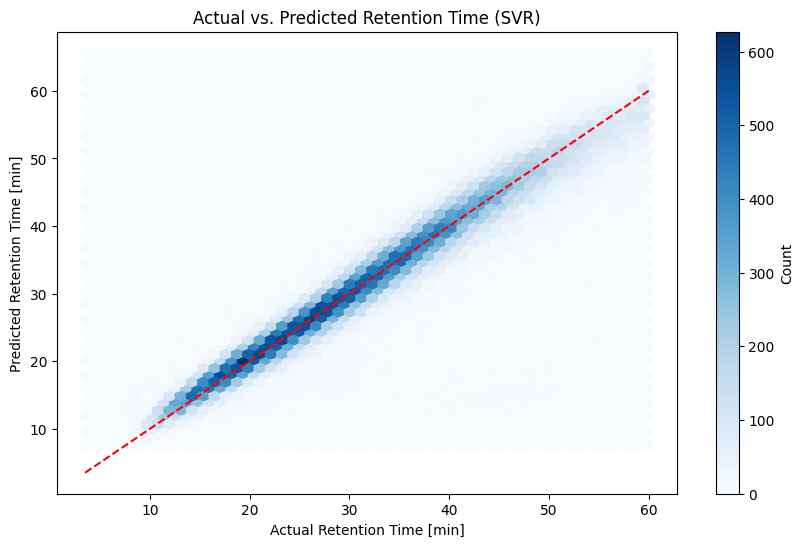

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sys


# Load data from CSV file containing prediction results.
# File should be provided via program args
#file_path = sys.argv[1]
#file_path = file_path.replace("\\", "//")
df = pd.read_csv(csv_file_path)

# Hexbin plot for predicted vs. actual retention time
plt.figure(figsize=(10, 6))
plt.hexbin(df['Actual'], df['Predicted'], gridsize=50, cmap='Blues')

# Add labels and title
plt.xlabel('Actual Retention Time [min]')
plt.ylabel('Predicted Retention Time [min]')
plt.title('Actual vs. Predicted Retention Time (SVR)')

# Plot x=y line
plt.plot([df['Actual'].min(), df['Actual'].max()], [df['Actual'].min(), df['Actual'].max()], color='red', linestyle='--')

# Add a colorbar
cb = plt.colorbar()
cb.set_label('Count')

# Show the plot
plt.show()


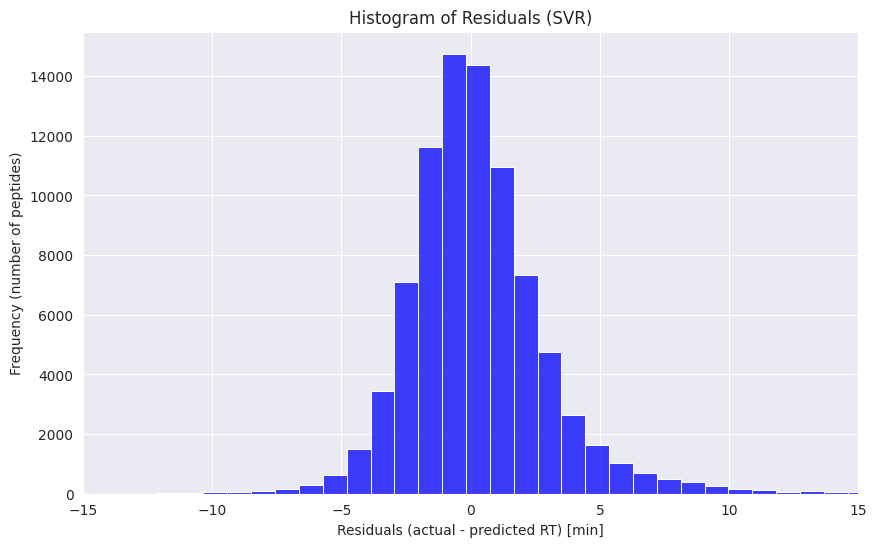

In [ ]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from CSV file containing prediction results.
# File should be provided via program args
df = pd.read_csv(csv_file_path)

# Calculate residuals
residuals = df['Actual'] - df['Predicted']

# Set the style to 'darkgrid'
sns.set_style('darkgrid')

# Plot histogram with seaborn
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=70, kde=False, color='blue')
plt.xlim(-15,15)
plt.title('Histogram of Residuals (SVR)')
plt.xlabel('Residuals (actual - predicted RT) [min]')
plt.ylabel('Frequency (number of peptides)')
plt.show()


# model

In [ ]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score



with h5py.File(file_mean_100, 'r') as hdf_file:
    # Convert datasets to float64 to ensure consistent data type
    X = np.column_stack((
        hdf_file['coef_C'][:].astype(np.float64),
        hdf_file['coef_N'][:].astype(np.float64),
        hdf_file['coef_avg'][:].astype(np.float64),
        hdf_file['coef_sum'][:].astype(np.float64),

        # hdf_file['count_A'][:].astype(np.float64),
        # hdf_file['count_C'][:].astype(np.float64),
        # hdf_file['count_D'][:].astype(np.float64),
        # hdf_file['count_E'][:].astype(np.float64),
        # hdf_file['count_F'][:].astype(np.float64),
        # hdf_file['count_G'][:].astype(np.float64),
        # hdf_file['count_H'][:].astype(np.float64),
        # hdf_file['count_I'][:].astype(np.float64),
        # hdf_file['count_K'][:].astype(np.float64),
        # hdf_file['count_L'][:].astype(np.float64),
        # hdf_file['count_M'][:].astype(np.float64),
        # hdf_file['count_N'][:].astype(np.float64),
        # hdf_file['count_P'][:].astype(np.float64),
        # hdf_file['count_Q'][:].astype(np.float64),
        # hdf_file['count_R'][:].astype(np.float64),
        # hdf_file['count_S'][:].astype(np.float64),
        # hdf_file['count_T'][:].astype(np.float64),
        # hdf_file['count_V'][:].astype(np.float64),
        # hdf_file['count_W'][:].astype(np.float64),
        # hdf_file['count_Y'][:].astype(np.float64),

        hdf_file['length'][:].astype(np.float64),
        hdf_file['ox_count'][:].astype(np.float64),
        hdf_file['pos_count'][:].astype(np.float64),
        hdf_file['sum_sq_diff_neighbour_coef'][:].astype(np.float64),
        hdf_file['highestCoefSum_5_neighbouring'][:].astype(np.float64),
        hdf_file['lowestCoefSum_5_neighbouring'][:].astype(np.float64),
        hdf_file['lowestCoefSum_2_neighbouring'][:].astype(np.float64),
        hdf_file['highestCoefSum_2_neighbouring'][:].astype(np.float64),
        hdf_file['coef_helical_moments'][:].astype(np.float64),
        hdf_file['coef_helical_scores'][:].astype(np.float64),
        hdf_file['sum_coef_neighboursOfPos'][:].astype(np.float64),
        hdf_file['sum_coef_neighbours_oxidized'][:].astype(np.float64),
        hdf_file['N_KyteDoolittle'][:].astype(np.float64),
        hdf_file['C_KyteDoolittle'][:].astype(np.float64),
        hdf_file['avg_Kyte_Doolittle'][:].astype(np.float64),
        hdf_file['sum_Kyte_Doolittle'][:].astype(np.float64)

    ))

    y = hdf_file['mean_retention_time'][:]

    # Get the dataset names for each feature
    feature_names = list(hdf_file.keys())[:-1]  #for saving results of model (Exclude 'median_retention_time')


# Split the data into training and holdout sets
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale input features to the [0, 1] range
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)

# Define the parameter search ranges
param_space = {
    'C': (0.01, 10.0, 'log-uniform'),
    'epsilon': (1e-6, 1.0, 'log-uniform'),
    'gamma': (1e-6, 1.5, 'log-uniform'),
}

# Create an ε-SVR model
svr = SVR(kernel='rbf')

# Create a BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=svr,
    search_spaces=param_space,
    n_iter=10,  # Adjust the number of iterations as needed
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Perform Bayesian hyperparameter tuning on the scaled training data
bayes_search.fit(X_train_scaled, y_train)

# Print the results of each iteration
results = bayes_search.cv_results_
for i, params in enumerate(results['params']):
    print(f"Iteration {i + 1}:")
    print(f"Parameters: {params}")
    print(f"Mean Test Score: {results['mean_test_score'][i]}")
    print(f"Standard Deviation Test Score: {results['std_test_score'][i]}")
    print()

# Get the best hyperparameters from the search
best_C = bayes_search.best_params_['C']
best_epsilon = bayes_search.best_params_['epsilon']
best_gamma = bayes_search.best_params_['gamma']

print("Best Hyperparameters:")
print(f"C: {best_C}")
print(f"Epsilon: {best_epsilon}")
print(f"Gamma: {best_gamma}")



# Create an ε-SVR model with the best hyperparameters
svr = SVR(kernel='rbf', C=best_C, epsilon=best_epsilon, gamma=best_gamma)

# Train the model on the scaled training data
svr.fit(X_train_scaled, y_train)

# Predict retention times on the scaled holdout data
y_pred = svr.predict(X_holdout_scaled)


# Evaluate the model's performance on the holdout set
mse = mean_squared_error(y_holdout, y_pred)
mae = mean_absolute_error(y_holdout, y_pred)
r2 = r2_score(y_holdout, y_pred)
correlation, _ = pearsonr(y_holdout, y_pred)

print(f"Mean Squared Error on Holdout Set: {mse}")
print(f"Mean Absolute Error on Holdout Set: {mae}")
print(f"R-squared on Holdout Set: {r2}")
print(f"Pearson Correlation on Holdout Set: {correlation}")


# Create a DataFrame for predicted and actual values and features
result_df = pd.DataFrame({'Actual': y_holdout, 'Predicted': y_pred})

# Add dataset names as column names for features
result_df = result_df.rename(columns={i: feature_names[i] for i in range(len(feature_names))})


# Save the DataFrame to a CSV file
result_df.to_csv('results_radial_svr_100.csv', index=False)

ModuleNotFoundError: ignored

In [ ]:
# no hyperparameter tuning

import h5py
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
#from skopt import BayesSearchCV


with h5py.File(file_mean_100, 'r') as hdf_file:
    # Convert datasets to float64 to ensure consistent data type
    X = np.column_stack((
        hdf_file['length'][:].astype(np.float64),
        hdf_file['ox_count'][:].astype(np.float64),
        hdf_file['pos_count'][:].astype(np.float64),

        hdf_file['coef_C'][:].astype(np.float64),
        hdf_file['coef_N'][:].astype(np.float64),
        hdf_file['coef_avg'][:].astype(np.float64),
        hdf_file['coef_sum'][:].astype(np.float64),
        hdf_file['sum_sq_diff_neighbour_coef'][:].astype(np.float64),
        hdf_file['highestCoefSum_5_neighbouring'][:].astype(np.float64),
        hdf_file['lowestCoefSum_5_neighbouring'][:].astype(np.float64),
        hdf_file['lowestCoefSum_2_neighbouring'][:].astype(np.float64),
        hdf_file['highestCoefSum_2_neighbouring'][:].astype(np.float64),
        hdf_file['coef_helical_moments'][:].astype(np.float64),
        hdf_file['coef_helical_scores'][:].astype(np.float64),
        #hdf_file['N_KyteDoolittle'][:].astype(np.float64),
        #hdf_file['C_KyteDoolittle'][:].astype(np.float64),
        hdf_file['avg_Kyte_Doolittle'][:].astype(np.float64),
        hdf_file['sum_Kyte_Doolittle'][:].astype(np.float64),
                hdf_file['sum_coef_neighboursOfPos'][:].astype(np.float64),
        hdf_file['sum_coef_neighbours_oxidized'][:].astype(np.float64)
    '


                # hdf_file['count_A'][:].astype(np.float64),
        # hdf_file['count_C'][:].astype(np.float64),
        # hdf_file['count_D'][:].astype(np.float64),
        # hdf_file['count_E'][:].astype(np.float64),
        # hdf_file['count_F'][:].astype(np.float64),
        # hdf_file['count_G'][:].astype(np.float64),
        # hdf_file['count_H'][:].astype(np.float64),
        # hdf_file['count_I'][:].astype(np.float64),
        # hdf_file['count_K'][:].astype(np.float64),
        # hdf_file['count_L'][:].astype(np.float64),
        # hdf_file['count_M'][:].astype(np.float64),
        # hdf_file['count_N'][:].astype(np.float64),
        # hdf_file['count_P'][:].astype(np.float64),
        # hdf_file['count_Q'][:].astype(np.float64),
        # hdf_file['count_R'][:].astype(np.float64),
        # hdf_file['count_S'][:].astype(np.float64),
        # hdf_file['count_T'][:].astype(np.float64),
        # hdf_file['count_V'][:].astype(np.float64),
        # hdf_file['count_W'][:].astype(np.float64),
        # hdf_file['count_Y'][:].astype(np.float64),

    ))

    y = hdf_file['mean_retention_time'][:]

    # Get the dataset names for each feature
    feature_names = list(hdf_file.keys())[:-1]  #for saving results of model (Exclude 'median_retention_time')


# Split the data into training and holdout sets
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale input features to the [0, 1] range
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)



# Create an ε-SVR model
svr = SVR(kernel='rbf', C=2, epsilon=0.25, gamma=1)


# Train the model on the scaled training data
svr.fit(X_train_scaled, y_train)

# Predict retention times on the scaled holdout data
y_pred = svr.predict(X_holdout_scaled)


# Evaluate the model's performance on the holdout set
mse = mean_squared_error(y_holdout, y_pred)
mae = mean_absolute_error(y_holdout, y_pred)
r2 = r2_score(y_holdout, y_pred)
correlation, _ = pearsonr(y_holdout, y_pred)

print(f"Mean Squared Error on Holdout Set: {mse}")
print(f"Mean Absolute Error on Holdout Set: {mae}")
print(f"R-squared on Holdout Set: {r2}")
print(f"Pearson Correlation on Holdout Set: {correlation}")


# Create a DataFrame for predicted and actual values and features
result_df = pd.DataFrame({'Actual': y_holdout, 'Predicted': y_pred})

# Add dataset names as column names for features
result_df = result_df.rename(columns={i: feature_names[i] for i in range(len(feature_names))})


# Save the DataFrame to a CSV file
result_df.to_csv('results_radial_svr_100.csv', index=False)

evaluation of all 3 models:

In [ ]:
# Plotting residual histogram for all models combined
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

# Load data from HDF5 file containing prediction results.
# Files should be provided via program args
hdf_file_path1 = sys.argv[1] #PR
hdf_file_path2 = sys.argv[2] #RF
hdf_file_path3 = sys.argv[3] #SVR

with h5py.File(hdf_file_path1, 'r') as hdf_file1, h5py.File(hdf_file_path2, 'r') as hdf_file2, h5py.File(hdf_file_path3, 'r') as hdf_file3:
    # Assuming 'mean_retention_time' and 'predicted_retention_time' are datasets in the HDF5 file
    observed_data1 = hdf_file1['mean_retention_time'][:]
    predicted_data1 = hdf_file1['predicted_retention_time'][:]

    observed_data2 = hdf_file2['mean_retention_time'][:]
    predicted_data2 = hdf_file2['predicted_retention_time'][:]

    observed_data3 = hdf_file3['actual'][:]
    predicted_data3 = hdf_file3['predicted'][:]

# Create DataFrames for both datasets
df1 = pd.DataFrame({'Actual': observed_data1, 'Predicted': predicted_data1})
df2 = pd.DataFrame({'Actual': observed_data2, 'Predicted': predicted_data2})
df3 = pd.DataFrame({'Actual': observed_data3, 'Predicted': predicted_data3})

# Calculate residuals for both datasets
residuals1 = df1['Actual'] - df1['Predicted']
residuals2 = df2['Actual'] - df2['Predicted']
residuals3 = df3['Actual'] - df3['Predicted']

# Set the style to 'darkgrid'
sns.set_style('darkgrid')

# Plot histogram with seaborn for both datasets
plt.figure(figsize=(10, 6))
#density based plot. To plot absolute values, simply remove 'stat = 'density'
sns.histplot(residuals1, bins=70, kde=False, color='black', label='Dataset 1', edgecolor='black', stat='density')
sns.histplot(residuals3, bins=70, kde=False, color='red', label='Dataset 1', alpha=0.6, stat='density')
sns.histplot(residuals2, bins=70, kde=False, color='cyan', label='Dataset 2', alpha=0.4, stat='density')
plt.xlim(-15, 15)
plt.title('Histogram of Residuals (standard input)')
plt.xlabel('Residuals (actual - predicted RT) (min)')
plt.ylabel('Density (count in bin / (total number of data points * bin width))')
plt.legend(labels=['Polynomial Regression', 'Support Vector Regression', 'Random Forest'])  # Set your custom labels here
plt.show()


# State of the art methods - working with their datasets

## factorizing our retention time prediction

In [ ]:
# finding the optimal scaling factor
import h5py
import numpy as np
from scipy.optimize import minimize
import sys

# Load data from HDF5 file
# file path to file containing the predictions on GPTime Datasets provided via program arguments
file_path = sys.argv[1]
with h5py.File(file_path, 'r') as file:
    mean_retention_time = file['mean_retention_time'][:]
    predicted_retention_time = file['predicted_retention_time'][:]

# Define the objective function to minimize
def objective_function(a):
    scaled_predictions = a * predicted_retention_time
    mse = np.mean((scaled_predictions - mean_retention_time)**2)
    return mse

# Initial guess for the scaling factor
initial_guess = 2.0

# Minimize the objective function to find the optimal scaling factor
result = minimize(objective_function, initial_guess, method='L-BFGS-B')

# Get the optimal scaling factor from the result
optimal_scaling_factor = result.x[0]

print(f"Optimal Scaling Factor: {optimal_scaling_factor}")


In [ ]:
# factorizing data and doing model evaluation based on that
import h5py
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import sys

# Load data from HDF5 file
file_path = sys.argv[1]  # Replace with your actual file path
factor = 1.988793714868752

with h5py.File(file_path, 'r+') as file:
    predicted_retention_time = file['predicted_retention_time'][:]
    mean_retention_time = file['mean_retention_time'][:]

    # Create a new dataset factorized_retention_time
    factorized_retention_time = factor * predicted_retention_time
    file.create_dataset('factorized_retention_time', data=factorized_retention_time)

# Calculate evaluation metrics
mse = mean_squared_error(mean_retention_time, factorized_retention_time)
mae = mean_absolute_error(mean_retention_time, factorized_retention_time)
r2 = r2_score(mean_retention_time, factorized_retention_time)
correlation, _ = pearsonr(mean_retention_time, factorized_retention_time)

# Print the results
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")
print(f"Pearson Correlation: {correlation}")
